# Import

In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

from multimode_expts.experiments.qsim.qsim_base import QsimBaseExperiment

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250812_qsim' # for data 
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250812_qsim


# Setup experiment hardware

In [3]:
expt_path=path+'\\data'

print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data


In [4]:
curr_path = os.getcwd()
# config_file = curr_path+'\\configs\\config_rfsoc_ziqian.yml'
config_file = curr_path+'\\configs\\hardware_config_202505.yml'
config_path = config_file
print('Config will be', config_path)

exp_param_file = curr_path+'\\configs\\experiment_config.yml'
exp_param_path = exp_param_file
print('Exp Param will be', exp_param_path)

Config will be c:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Exp Param will be c:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [5]:
qubit_i = 0
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [6]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab

In [7]:
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [8]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x15722f87f10; not connected; for PYRO:obj_590bd7a9236c437e94e83ebbfc72e107@192.168.137.101:35751>


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)

QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

# Choose experiment name

In [10]:
import sys

# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
# if expts_path not in sys.path:
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

# Floquet pulse calibrations

## Datset for Sidebands

In [11]:
from dataset import *
from dataset import floquet_storage_swap_dataset
import os 

file_path = os.path.join(expts_path, 'floquet_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = floquet_storage_swap_dataset(file_path)

ds_thisrun = floquet_storage_swap_dataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

Creating a copy of the dataset at path: floquet_storage_swap_dataset_copy.csv


stor_name  pi_frac   freq (MHz)  gain (DAC units)  len (mus)  \
0     M1-S1       12   348.712413              1006   0.302298   
1     M1-S2       12   519.951968              1341   0.310000   
2     M1-S3       12   696.041673              1157   0.310000   
3     M1-S4       12   873.467193              3026   0.250550   
4     M1-S5       12  1052.583825              2371   0.459513   
5     M1-S6       12  1244.545889              4458   0.339900   
6     M1-S7       12  1422.094111              3151   0.604046   

   ramp_sigma (mus)  phase_from_M1-S1 (deg)  phase_from_M1-S2 (deg)  \
0          0.005008                0.000000                0.739681   
1          0.005008               -1.064086                0.000000   
2          0.005008                1.375704                4.560000   
3          0.005008                0.000000                0.000000   
4          0.005008                0.000000                0.000000   
5          0.005008                0.000000                0.000000   
6          0.005008                0.000000                0.600000   

   phase_from_M1-S3 (deg)  phase_from_M1-S4 (deg)  phase_from_M1-S5 (deg)  \
0               -0.732612                     0.0                     0.0   
1               -3.810000                     0.0                     0.0   
2                0.000000                     0.0                     0.0   
3                0.000000                     0.0                     0.0   
4                0.000000                     0.0                     0.0   
5                0.000000                     0.0                     0.0   
6               -3.020000                     0.0                     0.0   

   phase_from_M1-S6 (deg)  phase_from_M1-S7 (deg)                 last_update  
0                     0.0                    0.00  2025-09-01 16:01:42.932357  
1                     0.0                  -13.26  2025-09-03 12:48:03.624911  
2                     0.0                    7.64  2025-09-03 12:48:03.627903  
3                     0.0                    0.00  2025-08-21 13:30:48.136503  
4                     0.0                    0.00  2025-08-21 13:30:48.146499  
5                     0.0                    0.00  2025-08-21 13:30:48.156493  
6                     0.0                    0.00  2025-09-03 12:48:03.630894

In [12]:
file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds_storage = storage_man_swap_dataset(file_path)
ds_storage.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   348.705722              NaN   1.209192    0.604596   
1      M1-S2   520.119712              NaN   1.157138    0.578569   
2      M1-S3   695.791320              NaN   1.057229    0.528615   
3      M1-S4   873.467193              NaN   1.002202    0.501101   
4      M1-S5  1052.583825              NaN   1.838050    0.919025   
5      M1-S6  1244.545889              NaN   1.359600    0.679800   
6      M1-S7  1422.176794              NaN   2.416182    1.208091   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2008.401343              NaN   0.592392    0.334310   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2313.176206             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               2977  2025-08-18 17:09:22.472298  
1               4765  2025-08-18 17:09:22.478282  
2               4883  2025-08-18 17:09:22.486261  
3               9080  2025-08-18 17:17:21.751136  
4               7115  2025-08-18 17:09:22.493242  
5              13375  2025-08-18 17:09:22.500224  
6               9522  2025-08-18 17:09:22.507236  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12              8000  2025-09-22 16:08:14.208414  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-06-04 17:23:32.148629  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

In [13]:
ds_thisrun.get_columns()

['stor_name',
 'pi_frac',
 'freq (MHz)',
 'gain (DAC units)',
 'len (mus)',
 'ramp_sigma (mus)',
 'phase_from_M1-S1 (deg)',
 'phase_from_M1-S2 (deg)',
 'phase_from_M1-S3 (deg)',
 'phase_from_M1-S4 (deg)',
 'phase_from_M1-S5 (deg)',
 'phase_from_M1-S6 (deg)',
 'phase_from_M1-S7 (deg)',
 'last_update']

In [14]:
# # Initializing this run dataset to some guess values based on standard storage pulses

# for s in range(1, 8, 1):
#     stor_name = f'M1-S{s}'
#     pi_frac = 12
#     freq = ds_storage.get_freq(f'M1-S{s}')
#     gain = ds_storage.get_gain(f'M1-S{s}') / 3
#     length = ds_storage.get_h_pi(f'M1-S{s}') / 2
#     ramp_sigma = soc.cycles2us(2, gen_ch=1)
#     ds_thisrun.update_freq(stor_name, freq)
#     ds_thisrun.update_pi_frac(stor_name, pi_frac)
#     ds_thisrun.update_gain(stor_name, gain)
#     ds_thisrun.update_len(stor_name, length)
#     ds_thisrun.update_ramp_sigma(stor_name, ramp_sigma)

# # Save dataset to file
# ds.df = ds_thisrun.df.copy()
# ds.save_to_file(ds.filename)

In [15]:
# file_path_old = os.path.join(expts_path, 'floquet_storage_swap_dataset_backup.csv')
# # print(os.makedirs(file_path, exist_ok=True))
# ds_backup = floquet_storage_swap_dataset(file_path_old)
# ds_backup.df

In [16]:
# # Initializing this run dataset to some values from another csv with different columns

# for s in range(1, 8, 1):
#     stor_name = f'M1-S{s}'
#     for col in ds_thisrun.df.columns:
#         if col in ds_backup.df.columns:
#             ds_thisrun.df[col] = ds_backup.df[col].copy()
#     # ds_thisrun.update_all(stor_name, pi_frac, freq, gain, length, ramp_sigma, stark_shift) 
# ds_thisrun.df
# # Save dataset to file
# ds.df = ds_thisrun.df.copy()
# ds.save_to_file(ds.filename)

In [17]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))
config_thisrun.device.storage.floquet_man_stor_file = ds_thisrun_file_path

In [18]:
from MM_dual_rail_base import MM_dual_rail_base
def get_floquet_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_thisrun.get_freq(stor_name)
    gain = ds_thisrun.get_gain(stor_name)
    length = ds_thisrun.get_len(stor_name)
    pi_frac = ds_thisrun.get_pi_frac(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    mm_base_dummy = MM_dual_rail_base(config_thisrun, soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, length, pi_frac, ch, prepulse, postpulse


## Freq chevron

  0%|          | 0/10 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00003_FloquetChevron_S7.h5


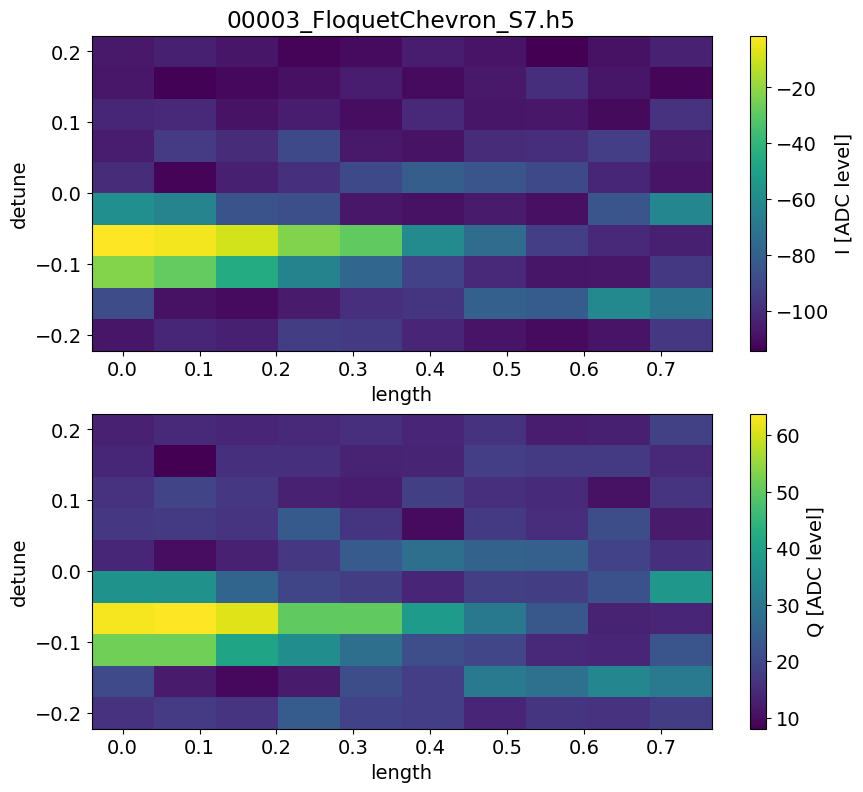

In [42]:
stor_modes_to_run = [7]
freq_len_expt = [None] * len(stor_modes_to_run)

for i, init_stor in enumerate(stor_modes_to_run): #range(1,8):
    ro_stor = 0

    # ds_thisrun.update_gain(f'M1-S{init_stor}', ds_thisrun.get_gain(f'M1-S{init_stor}') * 0.75)
    # print(f'Updating gain for M1-S{init_stor} to {ds_thisrun.get_gain(f"M1-S{init_stor}")}')

    expt_params = dict(
        expts = 1,
        reps = 100,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        detunes=np.linspace(-0.2, 0.2, 10).tolist(),
        lengths=np.linspace(0, 1.2 * ds_thisrun.get_len(f'M1-S{init_stor}'), 10).tolist(),
        swept_params = ['detune', 'length'],
        # detune = 0,
        # lengths=np.linspace(0, 1.5 * ds_thisrun.get_len(f'M1-S{init_stor}'), 30).tolist(),
        # swept_params = ['length'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        ds_thisrun=ds_thisrun,
    )
    
    qbe = meas.FloquetChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"FloquetChevron_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params=expt_params,
        program=meas.FloquetChevronProgram,
        progress=True)
    
    qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    qbe.go(analyze=False, display=True, progress=True, save=True)
    freq_len_expt[i] = qbe

In [43]:
qbe = freq_len_expt[0]
# qbe.analyze()

stor_name = f'M1-S{qbe.cfg.expt.init_stor}'
print(stor_name, ds_thisrun.get_len(stor_name))
# ds_thisrun.update_len(stor_name, 0.300)
ds_thisrun.update_freq(stor_name, ds_thisrun.get_freq(stor_name) - 0.05)

M1-S7 0.6040455746506244
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv


In [38]:
# Save dataset to file
ds.df = ds_thisrun.df.copy()
ds.save_to_file(ds.filename)

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv


## Error amplification on floquet pulses

In [18]:
def do_error_amp_floquet(
    config_thisrun,
    ds_thisrun,
    expt_path,
    config_path,
    reps=100,
    rounds=1,
    qubit=0,
    n_pulses=10,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    span = 1.0, # in units of either freq or gain depending on parameter_to_test
    expts = 25,
    parameter_to_test = 'frequency',
    man_mode_no=1,
    stor_mode_no=1,
    stor_is_dump=False,
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    freq, gain, length, pi_frac, ch, prepulse, postpulse = get_floquet_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    pulse_type = ['floquet', f'M{man_mode_no}-{"D" if stor_is_dump else "S"}{stor_mode_no}', f'pi/{pi_frac}', 0]


    if parameter_to_test == 'frequency':
        start = freq - span / 2
        step = span / (expts - 1)
    elif parameter_to_test == 'gain':
        start = int(gain - span / 2)
        step = int(span / (expts - 1))
    else:
        raise ValueError("parameter_to_test must be either 'frequency' or 'gain'.")
    
    expt_cfg = {
        'reps': reps,
        'qubit': qubit,
        'qubits': [qubit],
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'start': start,
        'expts': expts,
        'step': step,
        'n_pulses': n_pulses,
        'pulse_type': pulse_type,
        'parameter_to_test': parameter_to_test,
        'rounds': rounds,
    }

    error_amp_exp = meas.single_qubit.error_amplification.ErrorAmplificationExperiment(
    soccfg=soc, path=expt_path,
      prefix='ErrorAmplificationExperiment', config_file=config_path)
    error_amp_exp.cfg = AttrDict(deepcopy(config_thisrun))
    error_amp_exp.cfg.expt = expt_cfg
    error_amp_exp.go(analyze=False, display=False, progress=True, save=True)
    return error_amp_exp

In [34]:
stor_modes_to_run = [7]
error_amp_gain1 = [None] * len(stor_modes_to_run)
error_amp_freq1 = [None] * len(stor_modes_to_run)
error_amp_gain2 = [None] * len(stor_modes_to_run)
error_amp_freq2 = [None] * len(stor_modes_to_run)

In [52]:
ds_thisrun.update_gain('M1-S7', 3140)

Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv


Running M1-S7
cfg at start of acquire {'reps': 50, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 2890, 'expts': 50, 'step': 10, 'n_pulses': 15, 'pulse_type': ['floquet', 'M1-S7', 'pi/12', 0], 'parameter_to_test': 'gain', 'rounds': 1}
n_pts [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


  0%|          | 0/15 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00169_ErrorAmplificationExperiment.h5
fitparams [-4.645876770410152e-06, 1.0000046458767704, 3140, 49.0]


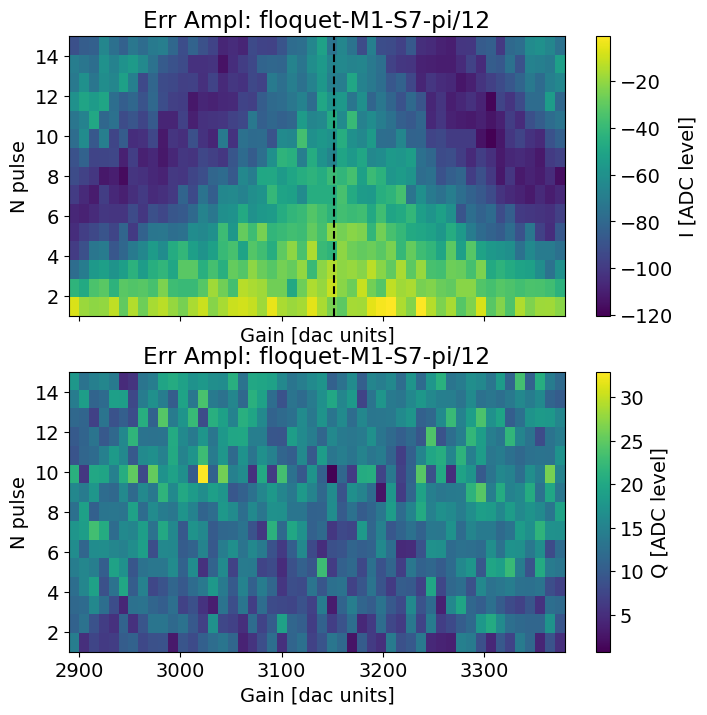

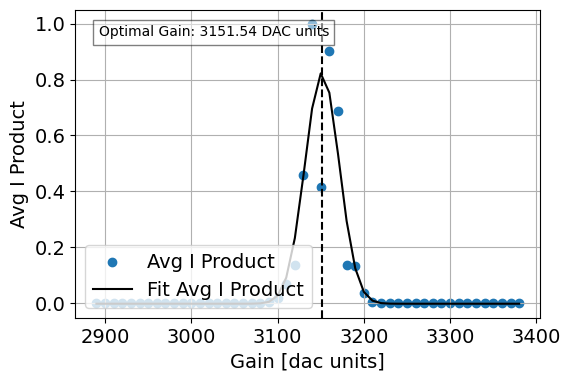

Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
cfg at start of acquire {'reps': 50, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 1422.070144300713, 'expts': 50, 'step': 0.0010204081632653062, 'n_pulses': 10, 'pulse_type': ['floquet', 'M1-S7', 'pi/12', 0], 'parameter_to_test': 'frequency', 'rounds': 1}
n_pts [ 1  2  3  4  5  6  7  8  9 10]


  0%|          | 0/10 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00170_ErrorAmplificationExperiment.h5
fitparams [-0.0024704953958328223, 1.0024704953958328, 1422.0915728721416, 0.0049999999999954525]


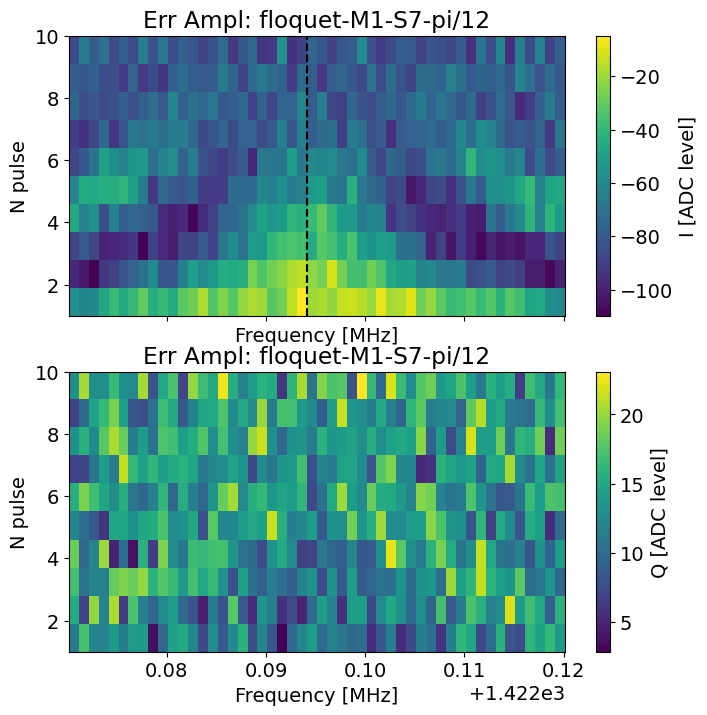

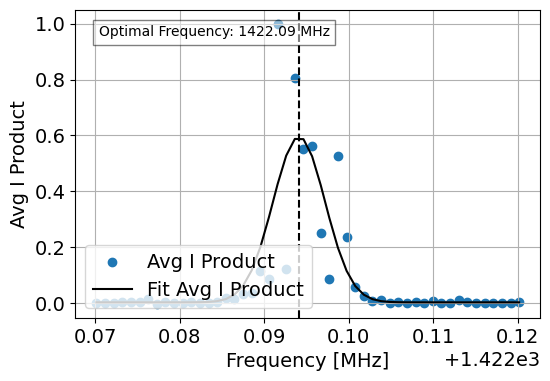

Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv


In [53]:
for i, stor_i in enumerate(stor_modes_to_run):
    stor_name = 'M1-S' + str(stor_i)
    print("Running", stor_name)

    error_amp_exp = do_error_amp_floquet(
        config_thisrun=config_thisrun,
        ds_thisrun=ds_thisrun,
        expt_path=expt_path,
        config_path=config_path,
        reps=50,
        rounds=1,
        qubit=0,
        n_pulses=15,
        active_reset=False,
        man_mode_no=1,
        stor_mode_no=stor_i,
        stor_is_dump=False,
        parameter_to_test='gain',
        span=500,
        expts=50,
    )
    error_amp_gain1[i] = error_amp_exp

    error_amp_exp.analyze(state_fin='e')
    error_amp_exp.display()
    opt_gain = error_amp_exp.data['fit_avgi'][2]
    ds_thisrun.update_gain(stor_name, opt_gain)


    error_amp_exp = do_error_amp_floquet(
        config_thisrun=config_thisrun,
        ds_thisrun=ds_thisrun,
        expt_path=expt_path,
        config_path=config_path,
        reps=50,
        rounds=1,
        qubit=0,
        n_pulses=10,
        active_reset=False,
        man_mode_no=1,
        stor_mode_no=stor_i,
        stor_is_dump=False,
        parameter_to_test='frequency',
        span=0.05,
        expts=50,
    )
    error_amp_freq1[i] = error_amp_exp

    error_amp_exp.analyze(state_fin='e')
    error_amp_exp.display()
    opt_freq = error_amp_exp.data['fit_avgi'][2]
    ds_thisrun.update_freq(stor_name, opt_freq)

fitparams [4.3746019957888794e-05, 0.9999562539800421, 2986, 49.0]


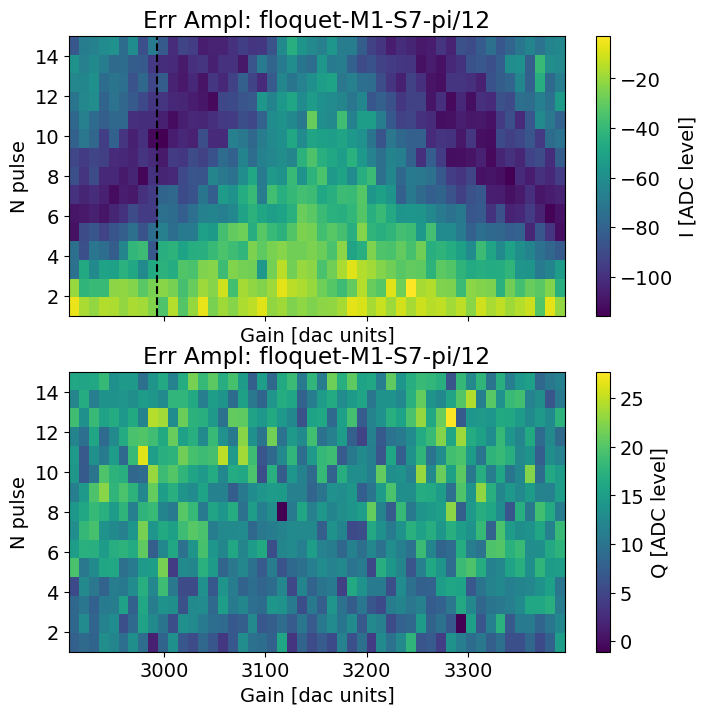

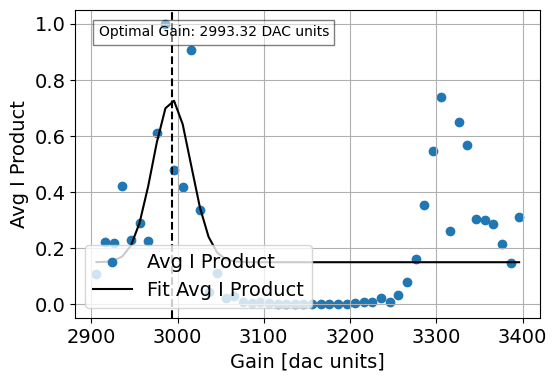

Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [-0.006090062999936566, 1.0060900629999365, 1422.0972485341174, 0.0049999999999954525]


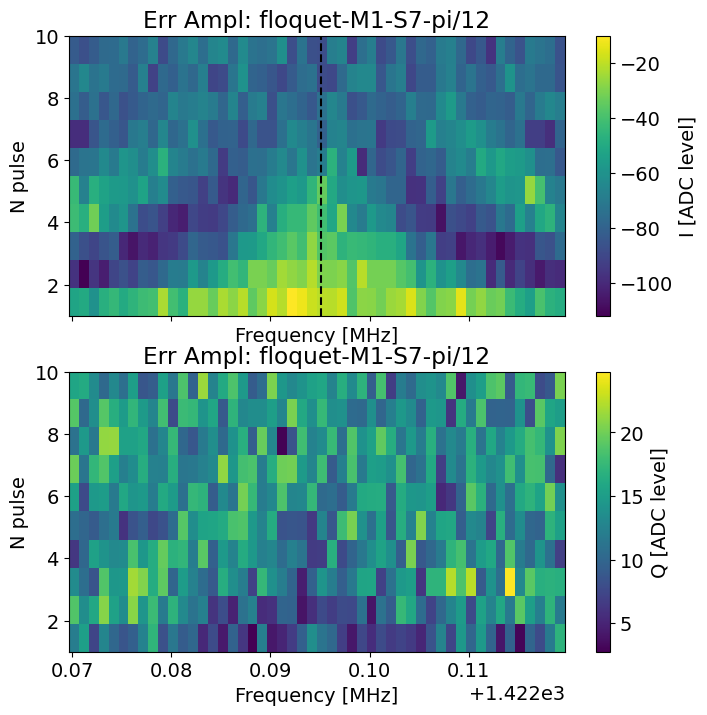

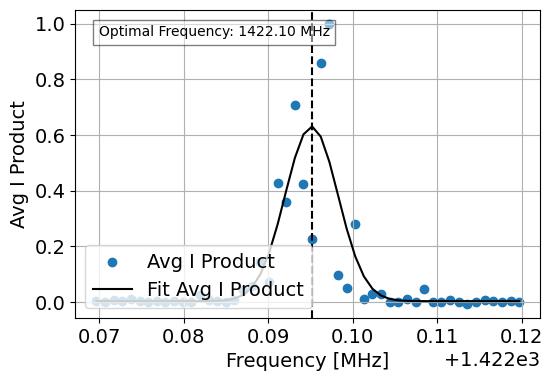

Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv


In [49]:
for i, stor_i in enumerate(stor_modes_to_run):
    stor_name = 'M1-S' + str(stor_i)

    error_amp_exp = error_amp_gain1[i]
    error_amp_exp.analyze(state_fin='g')
    error_amp_exp.display()
    opt_gain = error_amp_exp.data['fit_avgi'][2]
    ds_thisrun.update_gain(stor_name, opt_gain)

    error_amp_exp = error_amp_freq1[i]
    error_amp_exp.analyze(state_fin='e')
    error_amp_exp.display()
    opt_freq = error_amp_exp.data['fit_avgi'][2]
    ds_thisrun.update_freq(stor_name, opt_freq)

In [54]:
# Save dataset to file
ds.df = ds_thisrun.df.copy()
ds.save_to_file(ds.filename)

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv


## Phase accumulation matrix from stark shifts

In [55]:
phase_expts = [[None for _ in range(7)] for _ in range(7)]

Starting experiment for storage modes: 1 from 2
phase sweep [-10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


  0%|          | 0/6 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00003_SidebandStarkAmplification_S1_S2.h5


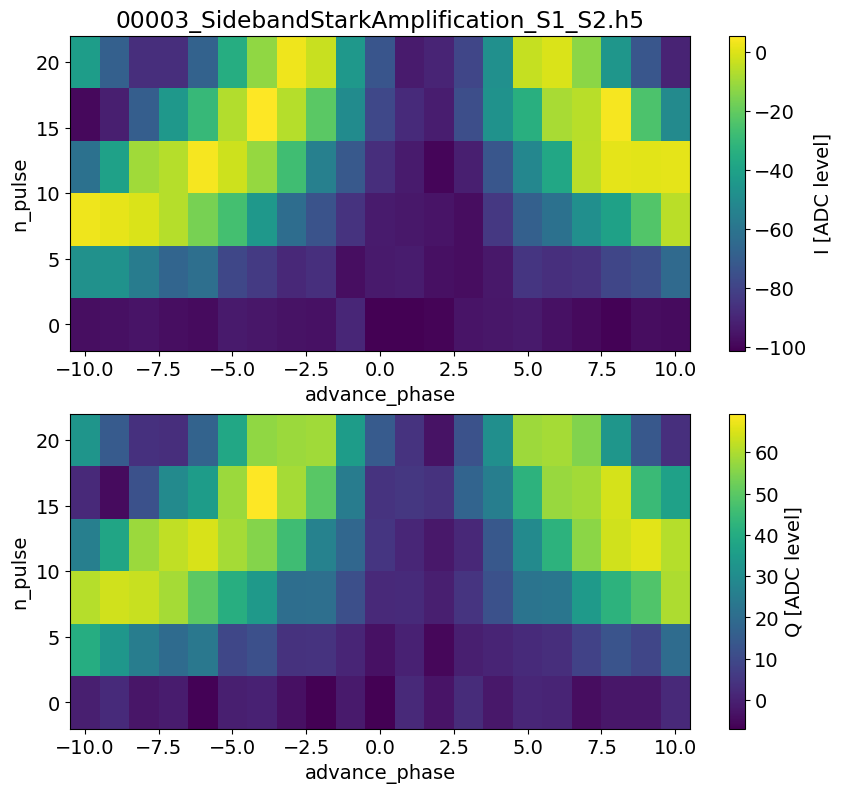

Starting experiment for storage modes: 2 from 1
phase sweep [-10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


  0%|          | 0/6 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00002_SidebandStarkAmplification_S2_S1.h5


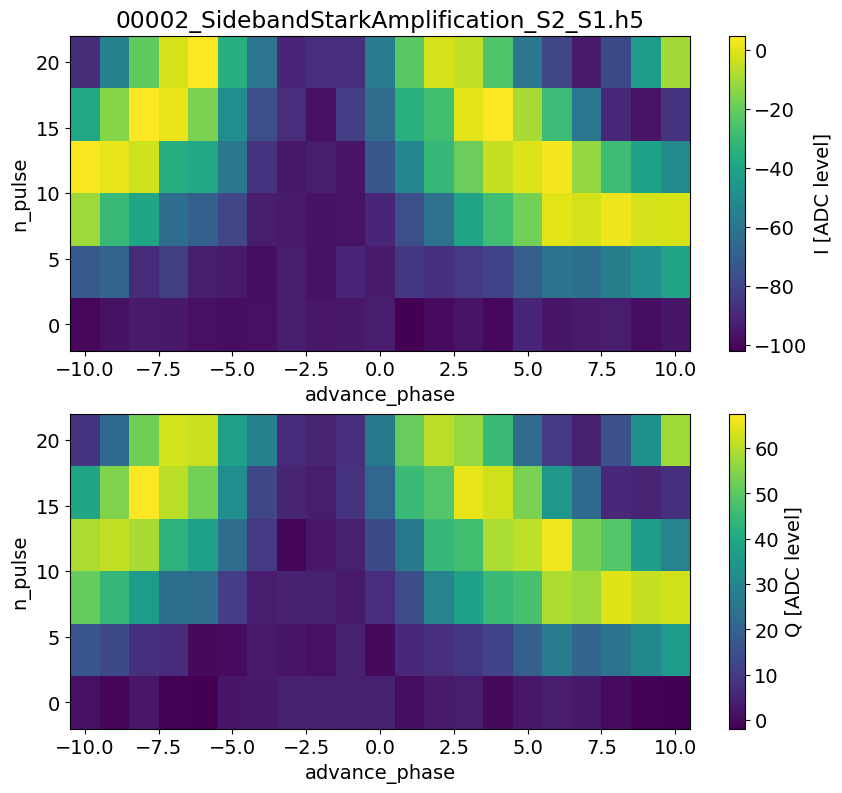

In [61]:
stor_modes_to_run = [1, 2]

for iA, init_storA in enumerate(stor_modes_to_run): #range(1,8):
    for iB, init_storB in enumerate(stor_modes_to_run): #range(1,8):
        if init_storA == init_storB:
            continue
        print("Starting experiment for storage modes:", init_storA, "from", init_storB)
        expt_params = dict(
            expts = 1,
            reps = 100,
            rounds = 1,
            qubits = [0],
            f0g1_cavity = 1,  #  1/2 name of manipulate cavity
            init_stor = 0, # storage mode number to initialize to n=1 Fock state (0 = man)
            ro_stor = 0, # storage mode number that gets read out in the end (0 = man)
            stor_A = init_storA, # storage mode on whose phase accumulation we will evaluate (relative to the stark shifted frequency)
            stor_B = init_storB, # storage mode on which a drive is applied which contributes the phase accumulation
            advance_phases = np.linspace(-10, 10, 21).tolist(),
            n_pulses = np.arange(0, 24, 4).tolist(),
            swept_params = ['n_pulse', 'advance_phase'],
            # usage: if you want to sweep cfg.expt.paramName, 
            # include paramName here in this list 
            # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
            # (You want a list instead of numpy array for better yaml export.)
            # Currently handles 1D and 2D sweeps and plots only.
            # For 2D, order is [outer (y), inner (x)].
            normalize = False, # not sure what this does
            active_reset = False,
            man_reset = True, 
            storage_reset = True, 
            ds_thisrun=ds_thisrun,
        )
        print("phase sweep", expt_params["advance_phases"])
    
        qbe = meas.SidebandStarkAmplificationExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"SidebandStarkAmplification_S{expt_params['stor_A']}_S{expt_params['stor_B']}",
            config_file=config_path,
            expt_params=expt_params,
            program=meas.SidebandStarkAmplificationProgram,
            progress=True)
    
        qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
        qbe.go(analyze=False, display=True, progress=True, save=True)
        phase_expts[init_storA - 1][init_storB - 1] = qbe

In [28]:
for iA, init_storA in enumerate(stor_modes_to_run): #range(1,8):
    for iB, init_storB in enumerate(stor_modes_to_run): #range(1,8):
        if init_storA == init_storB:
            continue
        stor_name = 'M1-S' + str(init_storA)
        from_stor_name = 'M1-S' + str(init_storB)
        qbe = phase_expts[init_storA - 1][init_storB - 1]
        qbe.analyze(fit=True)
        # qbe.display(fit=True)
        opt_phase = qbe.data['fit_avgi'][2] / 2 # divide by 2 since did pi/12, -pi/12 on the from_stor swap
        print("Opt phase on", stor_name, "from", from_stor_name, ":", opt_phase)
        ds_thisrun.update_phase_from(stor_name, from_stor_name, opt_phase)

fitparams [0.0012624003412228272, 0.9987375996587772, 1.5, 2.0]
Opt phase on M1-S1 from M1-S2 : 0.7396808820085534
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [0.004608970313470526, 0.9953910296865295, -1.0, 2.0]
Opt phase on M1-S1 from M1-S3 : -0.7326123737440323
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [0.008832596741336459, 0.9911674032586636, -2.5, 2.0]
Opt phase on M1-S2 from M1-S1 : -1.0640860485479129
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [0.0012016125630761314, 0.9987983874369238, -4.5, 2.0]
Opt phase on M1-S2 from M1-S3 : -1.8747449201378947
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [0.004669903766276481, 0.9953300962337235, 2.0, 2.0]
Opt phase on M1-S3 from M1-S1 : 1.3757035116688536
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [0.0049264894335033435, 0.995073

In [45]:
# Save dataset to file
ds.df = ds_thisrun.df.copy()
ds.save_to_file(ds.filename)

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv


In [1]:
ds_thisrun.df

NameError: name 'ds_thisrun' is not defined

In [63]:
ds.df

stor_name  pi_frac   freq (MHz)  gain (DAC units)  len (mus)  \
0     M1-S1       12   348.712413              1006   0.302298   
1     M1-S2       12   519.951968              1341   0.310000   
2     M1-S3       12   696.041673              1157   0.310000   
3     M1-S4       12   873.467193              3026   0.250550   
4     M1-S5       12  1052.583825              2371   0.459513   
5     M1-S6       12  1244.545889              4458   0.339900   
6     M1-S7       12  1422.094111              3151   0.604046   

   ramp_sigma (mus)  phase_from_M1-S1 (deg)  phase_from_M1-S2 (deg)  \
0          0.005008                0.000000                0.739681   
1          0.005008               -1.064086                0.000000   
2          0.005008                1.375704                2.287871   
3          0.005008                0.000000                0.000000   
4          0.005008                0.000000                0.000000   
5          0.005008                0.000000                0.000000   
6          0.005008                0.000000                0.000000   

   phase_from_M1-S3 (deg)  phase_from_M1-S4 (deg)  phase_from_M1-S5 (deg)  \
0               -0.732612                     0.0                     0.0   
1               -1.874745                     0.0                     0.0   
2                0.000000                     0.0                     0.0   
3                0.000000                     0.0                     0.0   
4                0.000000                     0.0                     0.0   
5                0.000000                     0.0                     0.0   
6                0.000000                     0.0                     0.0   

   phase_from_M1-S6 (deg)  phase_from_M1-S7 (deg)                 last_update  
0                     0.0                     0.0  2025-09-01 16:01:42.932357  
1                     0.0                     0.0  2025-09-01 16:01:42.937373  
2                     0.0                     0.0  2025-09-01 16:01:42.941360  
3                     0.0                     0.0  2025-08-21 13:30:48.136503  
4                     0.0                     0.0  2025-08-21 13:30:48.146499  
5                     0.0                     0.0  2025-08-21 13:30:48.156493  
6                     0.0                     0.0  2025-09-02 13:50:46.466370

In [70]:
ds.update_phase_from('M1-S2', 'M1-S3', -3.81)
ds.update_phase_from('M1-S2', 'M1-S7', -13.26)
ds.update_phase_from('M1-S3', 'M1-S2', 4.56)
ds.update_phase_from('M1-S3', 'M1-S7', 7.64)
ds.update_phase_from('M1-S7', 'M1-S2', 0.6)
ds.update_phase_from('M1-S7', 'M1-S3', -3.02)
ds.save_to_file('floquet_storage_1Derramp.csv')

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: floquet_storage_1Derramp.csv


In [69]:
ds.update_phase_from('M1-S2', 'M1-S3', -4.4)
ds.update_phase_from('M1-S2', 'M1-S7', -12.34)
ds.update_phase_from('M1-S3', 'M1-S2', 4.07)
ds.update_phase_from('M1-S3', 'M1-S7', 8.56)
ds.update_phase_from('M1-S7', 'M1-S2', 1.24)
ds.update_phase_from('M1-S7', 'M1-S3', -3.02)
ds.save_to_file('floquet_storage_2Derramp.csv')

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: floquet_storage_2Derramp.csv


# AC Stark calibration with pi/2 dual rail

  0%|          | 0/31 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00000_FloquetPhaseCal_2on3_via1.h5
('Error in saving cfg into datafile (experiment.py):', TypeError('Object of type floquet_storage_swap_dataset is not JSON serializable'))


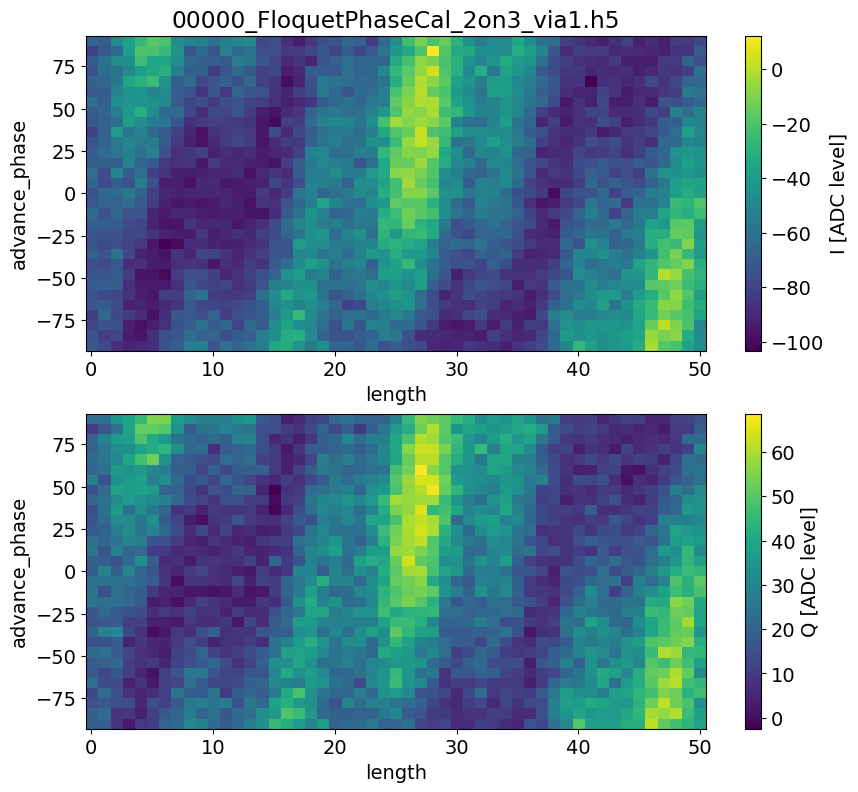

In [25]:
expt_params = dict(
    expts = 1,
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 0, # storage mode number to initialize to n=1 Fock state
    ro_stor = 0, # storage mode number that gets read out in the end
    stor_row = 3,
    stor_col = 2,
    stor_idle = 1,
    # if 0, this means to read out man instead
    # detunes=np.linspace(-0.2, 0.2, 10).tolist(),
    # lengths=np.linspace(0, 1.5 * ds_thisrun.get_len(f'M1-S{init_stor}'), 10).tolist(),
    # swept_params = ['detune', 'length'],
    advance_phases=np.linspace(-90,90,31).tolist(),
    lengths=np.linspace(0.1, 50, 51).tolist(),
    swept_params = ['advance_phase', 'length'],
    # usage: if you want to sweep cfg.expt.paramName, 
    # include paramName here in this list 
    # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
    # (You want a list instead of numpy array for better yaml export.)
    # Currently handles 1D and 2D sweeps and plots only.
    # For 2D, order is [outer, inner].
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    ds_thisrun=ds_thisrun,
)

qbe = meas.FloquetPhaseCalExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetPhaseCal_{expt_params['stor_col']}on{expt_params['stor_row']}_via{expt_params['stor_idle']}",
    config_file=config_path,
    expt_params=expt_params,
    program=meas.FloquetPhaseCalProgram,
    progress=True)

qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
qbe.go(analyze=False, display=True, progress=True, save=True)
# freq_len_expt[i] = qbe

## Use the period of the 2 storage + M1 random walk to error amplify the phase calibration

Starting experiment for storage modes: 2 from 7
n_scramble_cycles [0, 1, 2, 3]
phase sweep A [-15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]
phase sweep B [-15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]
Starting experiment for n_scramble_cycle 0 with total floquet cycles 17


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 1 with total floquet cycles 51


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 2 with total floquet cycles 85


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 3 with total floquet cycles 119


  0%|          | 0/61 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00000_FloquetCalibrationAmplificationExperiment_S2_S7.h5
Starting experiment for storage modes: 3 from 7
n_scramble_cycles [0, 1, 2, 3]
phase sweep A [-15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]
phase sweep B [-15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]
Starting experiment for n_scramble_cycle 0 with total

  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 1 with total floquet cycles 51


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 2 with total floquet cycles 85


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 3 with total floquet cycles 119


  0%|          | 0/61 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00000_FloquetCalibrationAmplificationExperiment_S3_S7.h5


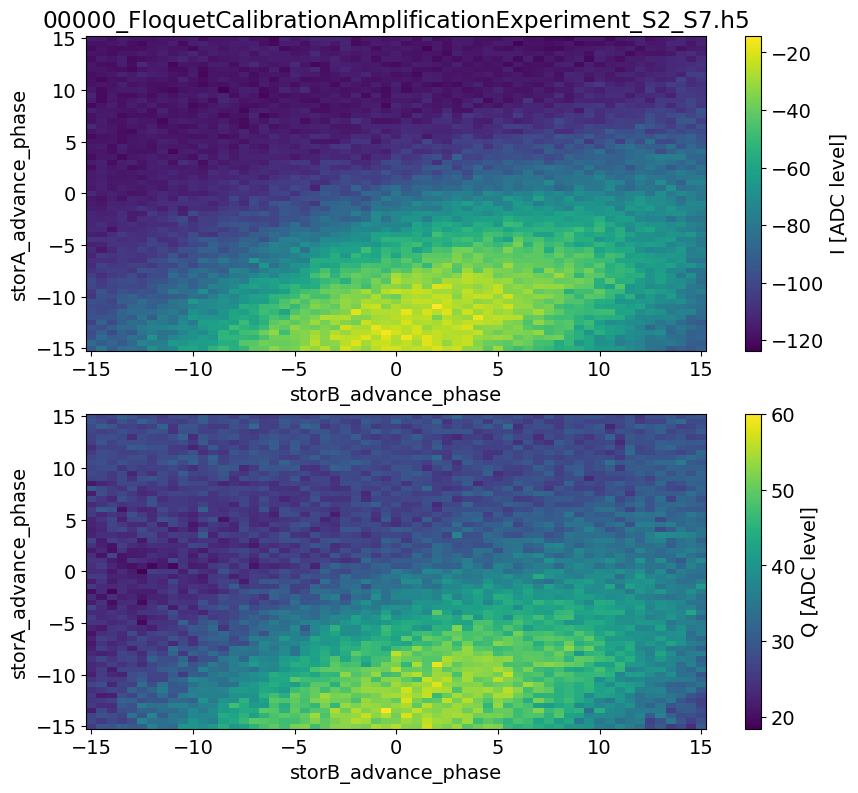

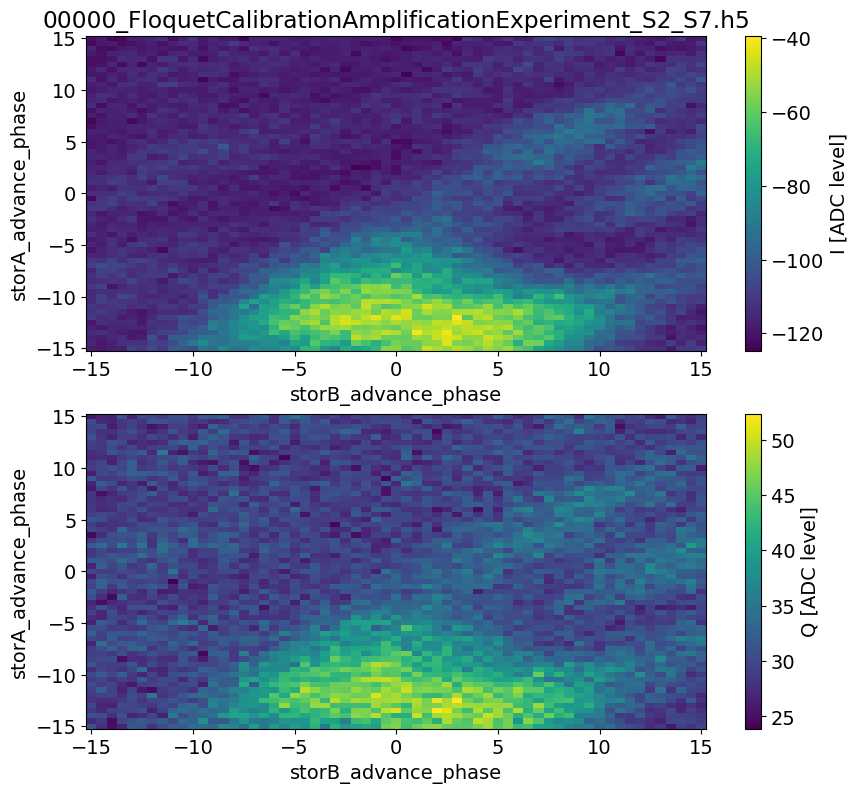

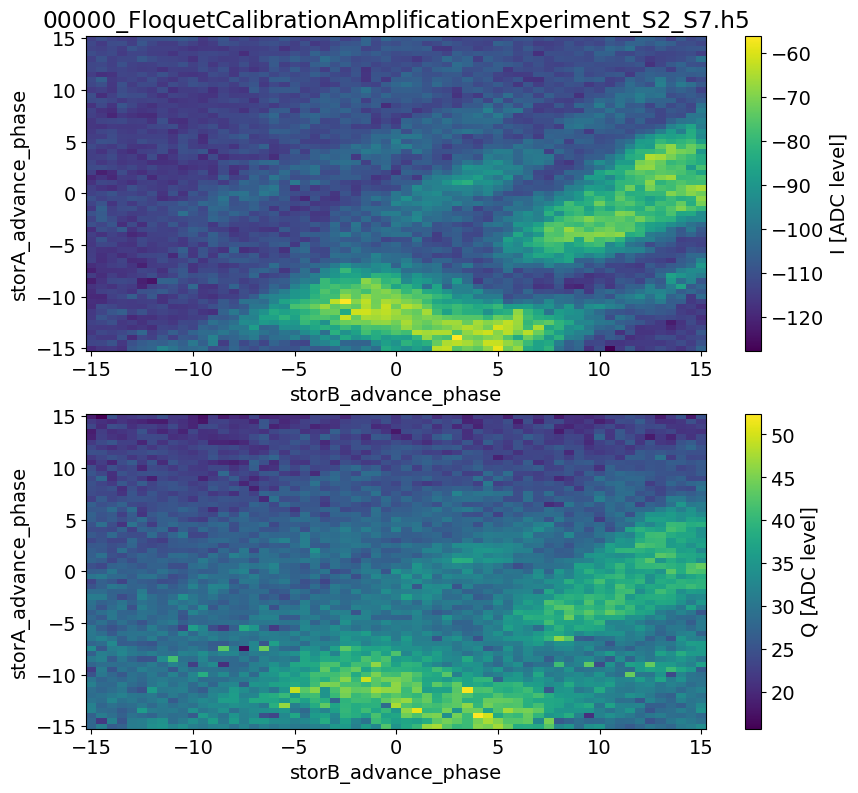

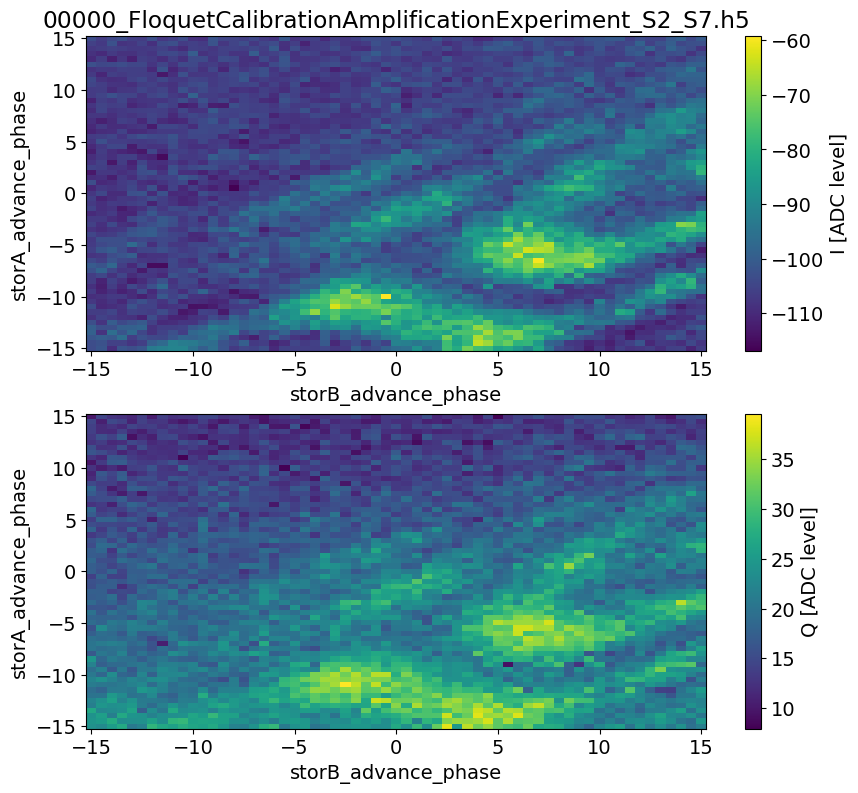

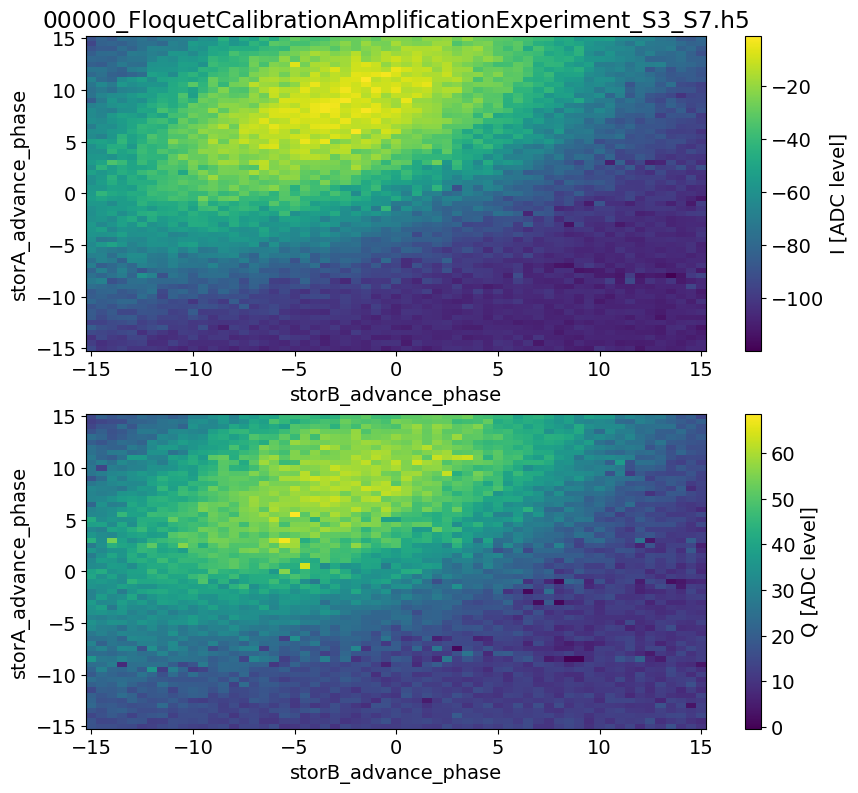

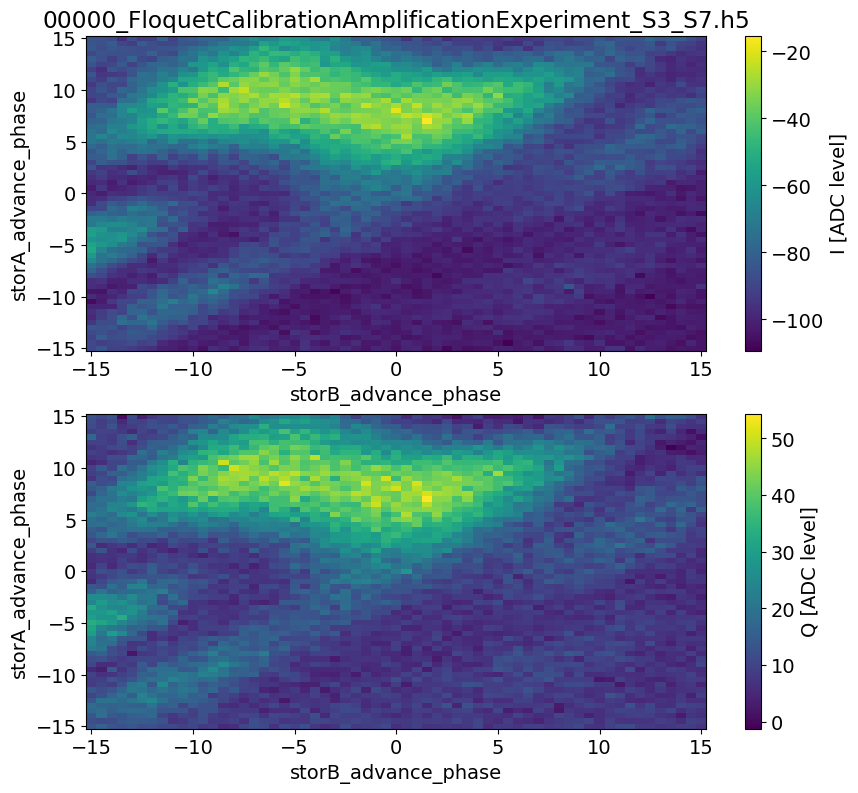

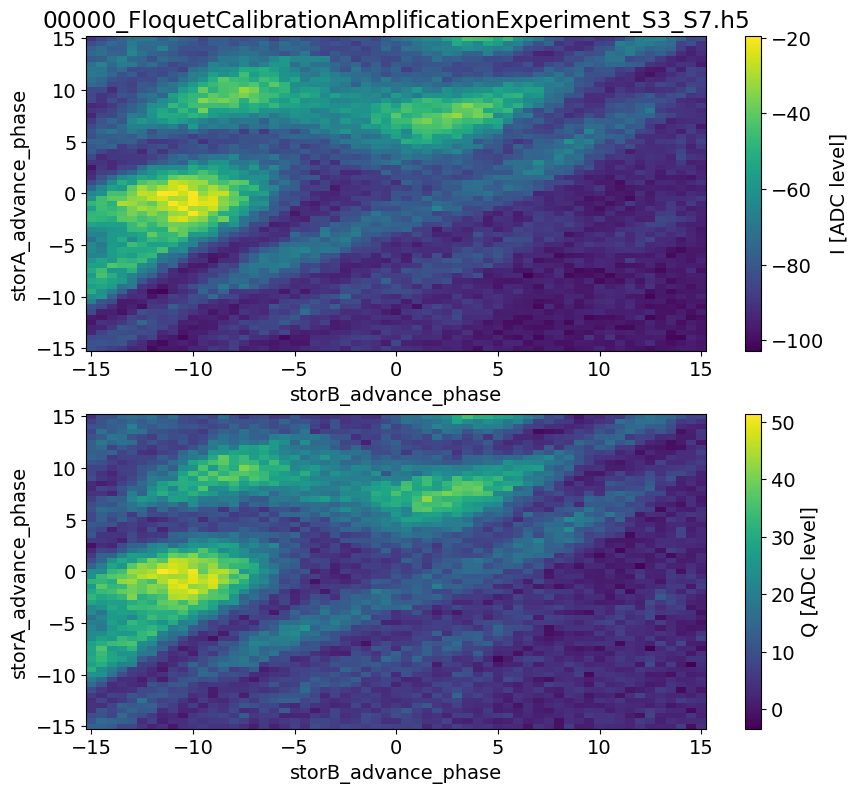

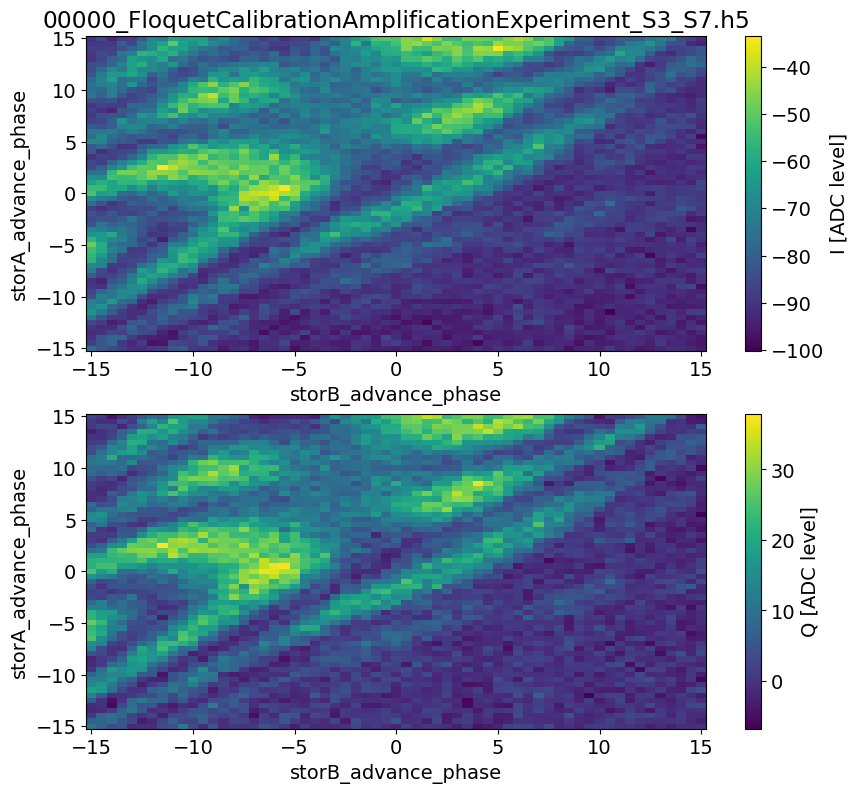

In [59]:
# storA = 2
# storB = 3

for storA, storB in [(2,7),(3,7)]:
    print("Starting experiment for storage modes:", storA, "from", storB)
    n_scramble_cycles = [0,1,2,3]
    n_floquet_per_scramble = 17 # = for omega1=omega2 the period is 2sqrt(2) * pi_frac

    floquet_cycles = n_floquet_per_scramble * n_scramble_cycles

    expt_params = dict(
        expts = 1,
        reps = 200,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = storA, # storage mode number to initialize to n=1 Fock state (0 = man)
        ro_stor = storB, # storage mode number that gets read out in the end (0 = man)
        storA = storA, # storage mode on whose phase accumulation we will evaluate (relative to the stark shifted frequency)
        storB = storB, # storage mode on which a drive is applied which contributes the phase accumulation
        storA_advance_phases = np.linspace(-15, 15, 61).tolist(),
        storB_advance_phases = np.linspace(-15, 15, 61).tolist(),
        n_scramble_cycles = n_scramble_cycles,
        n_floquet_per_scramble = n_floquet_per_scramble,
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer (y), inner (x)].
        normalize = False, # not sure what this does
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        ds_thisrun=ds_thisrun,
    )
    print("n_scramble_cycles", expt_params["n_scramble_cycles"])
    print("phase sweep A", expt_params["storA_advance_phases"])
    print("phase sweep B", expt_params["storB_advance_phases"])

    qbe = meas.FloquetCalibrationAmplificationExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"FloquetCalibrationAmplificationExperiment_S{expt_params['storA']}_S{expt_params['storB']}",
        config_file=config_path,
        expt_params=expt_params,
        program=meas.FloquetCalibrationProgram,
        progress=True)

    qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    qbe.acquire(progress=True, debug=True)
    qbe.save_data()

In [ ]:
qbe.save_data()
# qbe.analyze()

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00000_FloquetCalibrationAmplificationExperiment_S1_S2.h5


array([1])

# Qsim

## Initial random try

In [24]:
import multimode_expts.experiments.qsim.qsim_experiments as qsim_exp

experiment_name = 'storage_sweep'

flqSwap = qsim_exp.floquet_swap_class(
    soccfg=soc, 
    path=expt_path, 
    prefix=experiment_name, 
    config_file=config_path, 
    exp_param_file=os.path.join(curr_path, 'configs', 'qsim_exp_cfg.yml')
)

flqSwap.run_sweep( sweep_experiment_name = experiment_name)

Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}


  0%|          | 0/7 [00:00<?, ?it/s]

[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8

## Sideband Ramsey

This is starting to test our channel phases: when we switch from one channel generator freq to diff freq (activating different storage swaps), does our code preserve phase coherence between the successive (partial) pulses. 

We start from a simple M1-Sx Ramsey: qubit ge, qubit ef, f0g1 to initialize man1 into |1>, then do pi/2 on the beam splitter and wait and another pi/2.

In [72]:
from multimode_expts.experiments.qsim.sideband_ramsey_scramble import SidebandRamseyExperiment

In [24]:
from multimode_expts.experiments.qsim.sideband_ramsey import SidebandRamseyExperiment

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_SidebandRamsey_M1S1.h5
Current pi pulse frequency: 3571.709750355705
Fit frequency from I [MHz]: 0.3089569532058502 +/- 0.0008688187687284037
Suggested new pi pulse frequency from fit I [MHz]:
 	3571.600793402499
 	3572.2187073089112
T2 Ramsey from fit I [us]: 151.35019342478705
Fit frequency from Q [MHz]: 0.3081087340680849 +/- 0.0012433866916204631
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3571.601641621637
 	3572.2178590897734
T2 Ramsey from fit Q [us]: 91.19102876798401


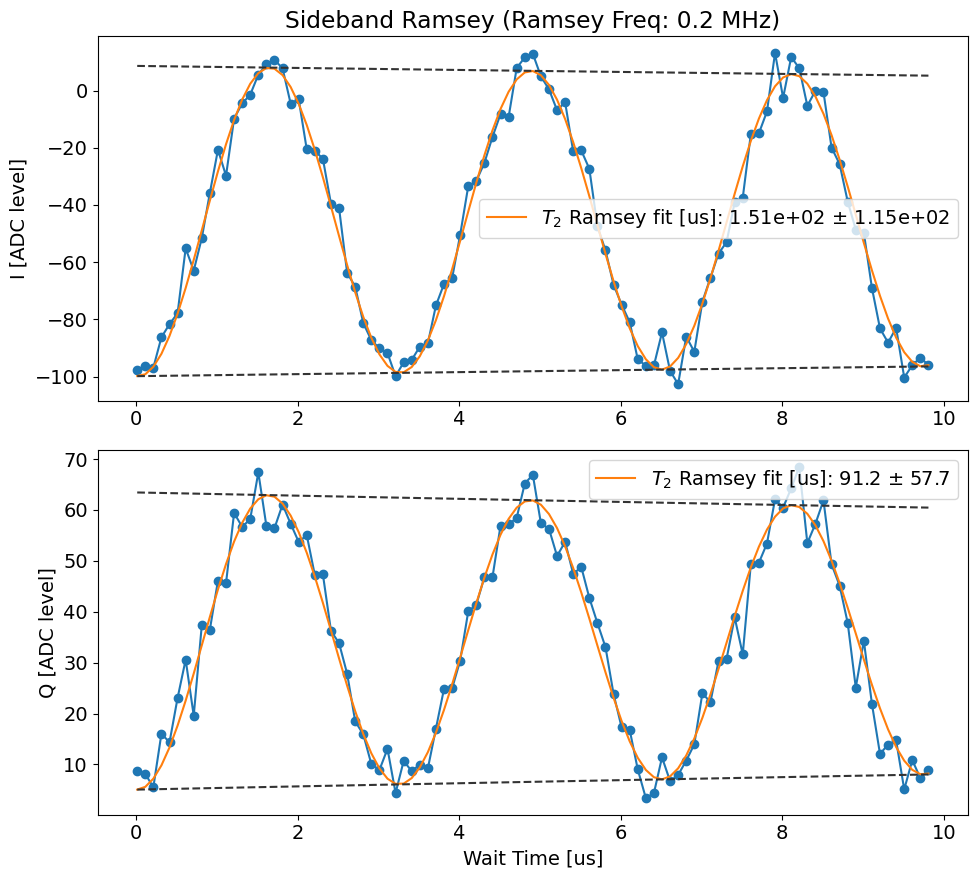

In [27]:
expt_params = dict(
    start = 0.01, # wait time tau [us]
    step = 0.1,  # [us] 1 cycle is 0.0023251488095238095 [us], 2.7901785714285716 # [us]=1200 cycles
    expts = 100,
    ramsey_freq = 0.2, # [MHz]
    detune = 0,
    ac_stark=0.5, # [MHz] not sure how to define sign yet
    # but in any case this needs to be smaller than ramsey_freq
    # because qick can't handle negative numbers
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    stor_no = 1, # storage mode number, 1 to 7
    normalize = False,
    active_reset = True,
    man_reset = True, 
    storage_reset = True, 
    advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
    echoes = [False, 0], # [on/off, number of echoes]
)

sbr = SidebandRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandRamsey_M1S{expt_params['stor_no']}",
    config_file=config_path,
    expt_params = expt_params,
    progress=True)

sbr.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
# sbr.acquire()
sbr.go(analyze=True, display=True, progress=True, save=True)

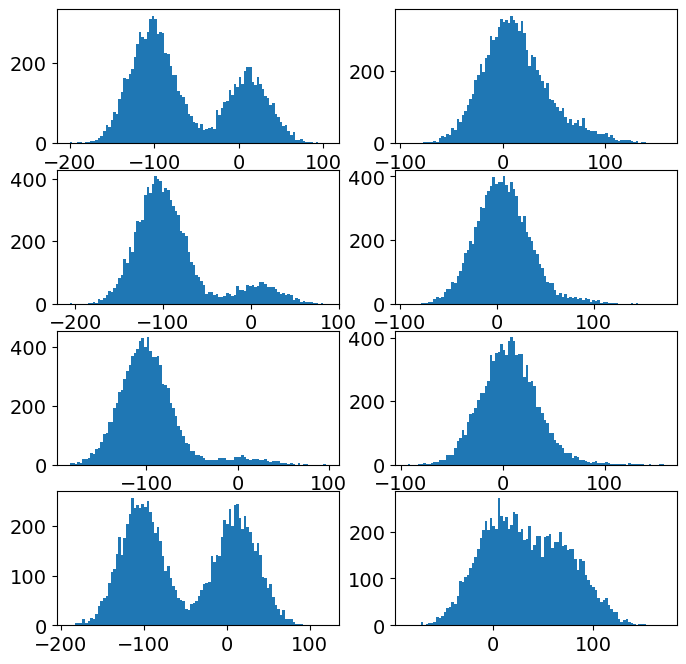

In [28]:
idata = sbr.data['idata']
idata = idata.reshape((len(idata)//4,4))

qdata = sbr.data['qdata']
qdata = qdata.reshape((len(qdata)//4,4))

fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
for kk in range(4):
    axs[kk,0].hist(idata[:,kk], bins=100)
    axs[kk,1].hist(qdata[:,kk], bins=100)
None

In [ ]:
0.327922332524605 # current reset version
0.32806373843420333 # without reset
0.3264759424279595 # reset with 100us wait
0.3274569103286323 # only 0 to N+1
0.328382941835013 # only -N to 0
0.327225195204317 # only 0
0.325693135972055 # n set to 30
0.32566986782848 # add 100 to m1d1

### 2D chevron

In [82]:
from multimode_expts.experiments.qsim.sideband_ramsey import SidebandChevronExperiment

In [90]:
expt_params = dict(
    start = 0.01, # wait time tau [us]
    step = 0.05,  # [us] 1 cycle is 0.0023251488095238095 [us], 2.7901785714285716 # [us]=1200 cycles
    expts = 100,
    ramsey_freq = 0.1, # [MHz]
    ac_stark=0.5,
    detune = 0,
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    stor_no = 1, # storage mode number, 1 to 7
    normalize = False,
    active_reset = False,
    # man_reset = False, 
    # storage_reset = False, 
    advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
    echoes = [False, 0], # [on/off, number of echoes]
)

for stor_no in [5]: #range(1,8):
    expt_params['stor_no'] = stor_no
    sbr = SidebandChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandChevron_M1S{stor_no}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    # sbr.acquire()
    sbr.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00001_SidebandChevron_M1S5.h5


In [85]:
sbr.data.keys()

dict_keys(['avgi', 'avgq', 'amps', 'phases', 'idata', 'qdata', 'xpts', 'ypts'])

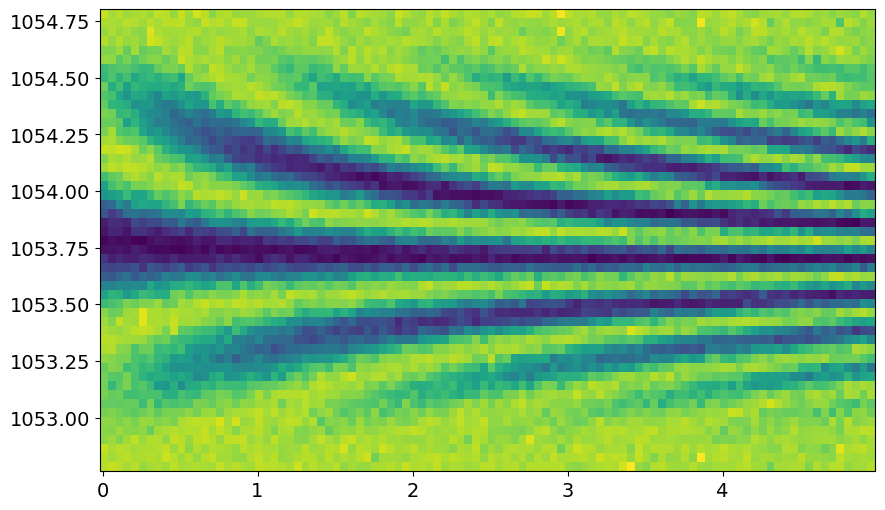

In [91]:
plt.pcolormesh(sbr.data['xpts'], sbr.data['ypts'], sbr.data['avgi'])

## Sideband scramble

In [16]:
from multimode_expts.experiments.qsim.sideband_scramble import SidebandScrambleProgram

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.deprecated
imported experiments.qsim.floquet_chevron
imported experiments.qsim.floquet_offdiag_phasecal
imported experiments.qsim.qsim_base
imported experiments.qsim.sideband_amp_rabi
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.sideband_scramble
imported experiments.qsim.sideband_stark
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
imported ex

  0%|          | 0/201 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00003_SidebandScramble_S0_to_S2.h5


  0%|          | 0/201 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00003_SidebandScramble_S0_to_S3.h5


  0%|          | 0/201 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00003_SidebandScramble_S0_to_S7.h5


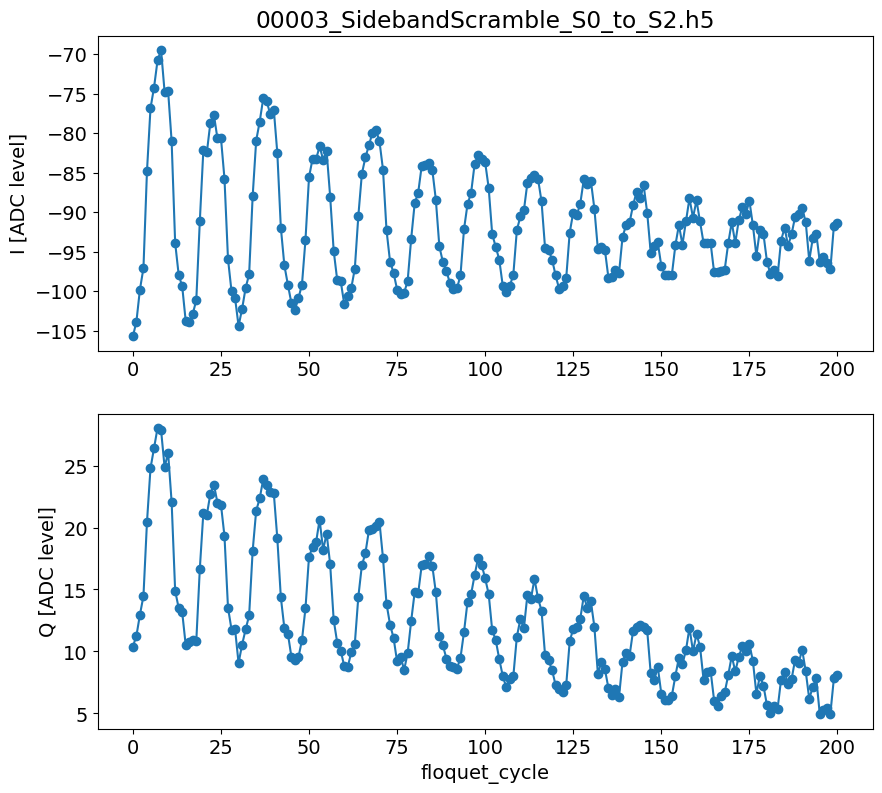

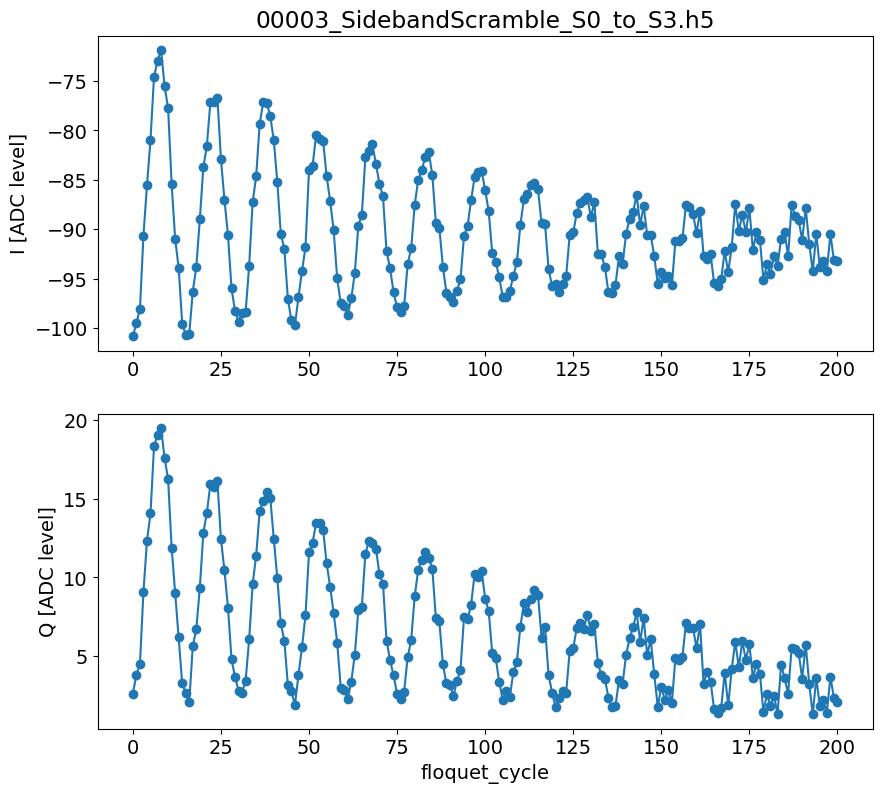

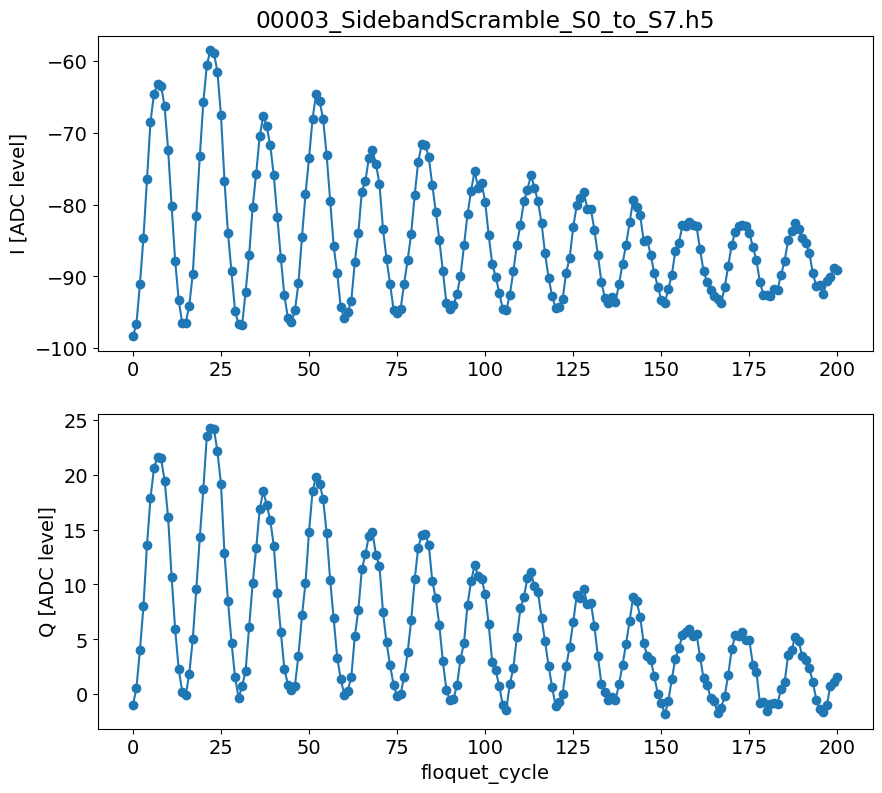

In [17]:
meas_stors = [2, 3, 7]

for update_phases in [True]: # [False, True]:
    for meas_stor in meas_stors:
        expt_params = dict(
            expts = 1,
            reps = 300,
            rounds = 20,
            qubits = [0],
            f0g1_cavity = 1,  #  name of manipulate cavity (1 or 2)
            init_stor = 0, # storage mode number to initialize to n=1 Fock state
            ro_stor = meas_stor, # storage mode number that gets read out in the end
            # if 0, this means to read out man instead
            floquet_cycles = list(range(0, 201)),
            detune=0,
            normalize = False,
            active_reset = False,
            man_reset = True, 
            storage_reset = True, 
            # advance_phase=3,
            # swept_params = ['advance_phase', 'floquet_cycle'],
            swept_params = ['floquet_cycle'],
            swap_stors = [2, 3, 7],
            floquet_dataset_filename = 'floquet_storage_2Derramp.csv',
            update_phases = update_phases, 
            echoes = [False, 0], # [on/off, number of echoes]
        )
    
        sbs = meas.QsimBaseExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
            config_file=config_path,
            expt_params = expt_params,
            program = meas.SidebandScrambleProgram,
            progress=True)
    
        sbs.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
        sbs.go(analyze=False, display=True, progress=True, save=True)

### Phase calibration using quantum walk

In [47]:
from multimode_expts.experiments.qsim.sideband_scramble import FloquetCalibrationProgram

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_FloquetCalibration_S1_to_S3.h5


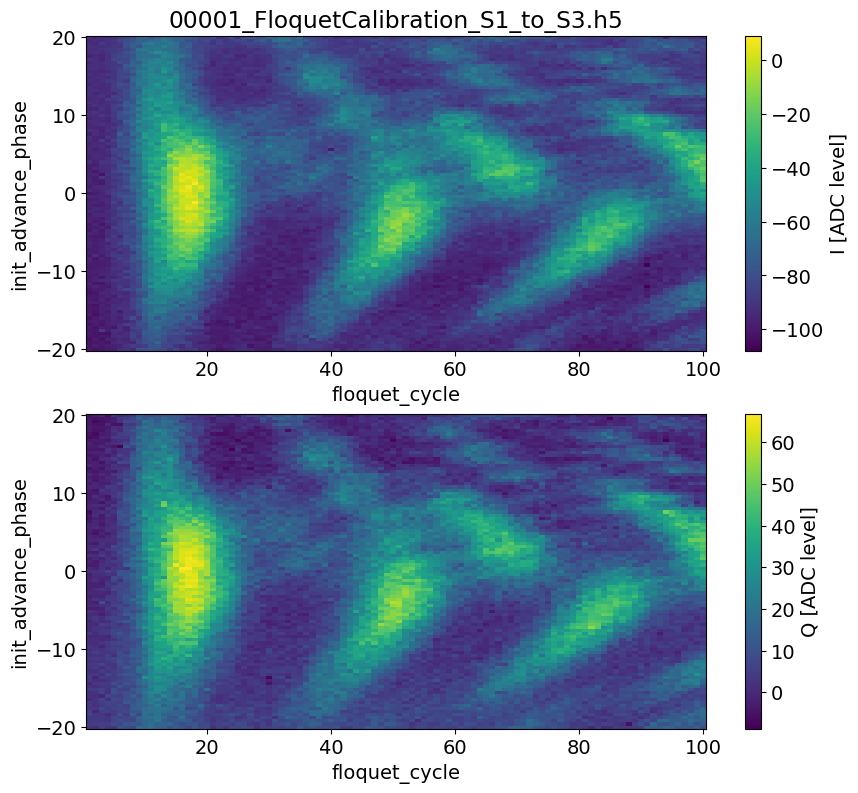

In [50]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 1, # storage mode number to initialize to n=1 Fock state
    ro_stor = 3, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = np.linspace(-20,20,101).tolist(), # advance phase of each successive pulse for the init mode[degrees]
    ro_advance_phase = 5,
    # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
    swept_params = ['init_advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

fce = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = FloquetCalibrationProgram,
    progress=True)

fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
fce.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_FloquetCalibration_S3_to_S1.h5


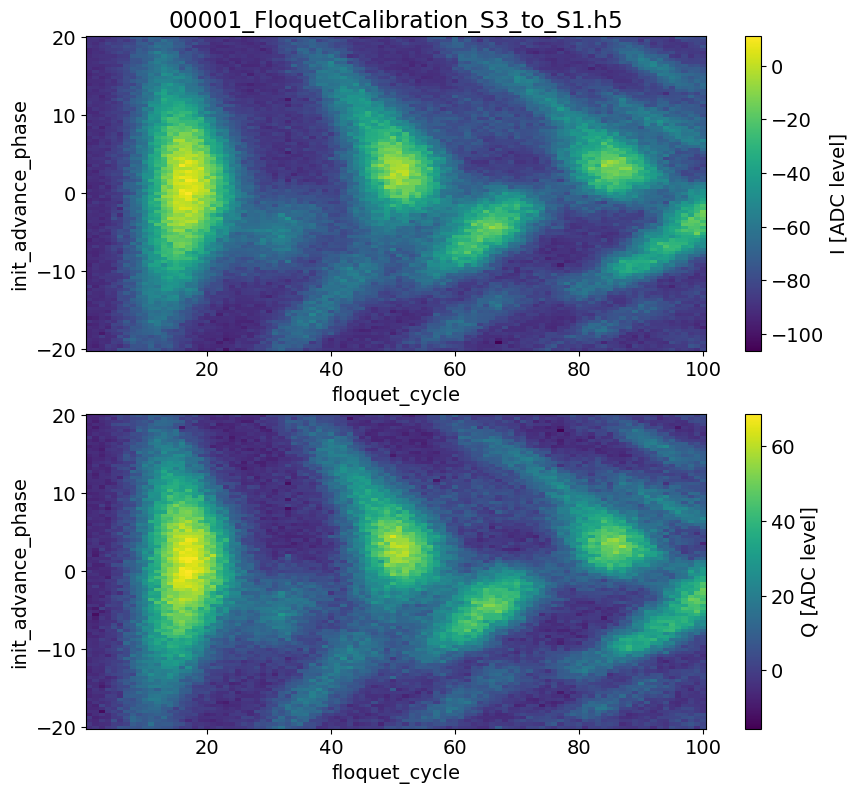

In [51]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 3, # storage mode number to initialize to n=1 Fock state
    ro_stor = 1, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = np.linspace(-20,20,101).tolist(), # advance phase of each successive pulse for the init mode[degrees]
    ro_advance_phase = -4,
    # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
    swept_params = ['init_advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

fce = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = FloquetCalibrationProgram,
    progress=True)

fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
fce.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_FloquetCalibration_S2_to_S3.h5


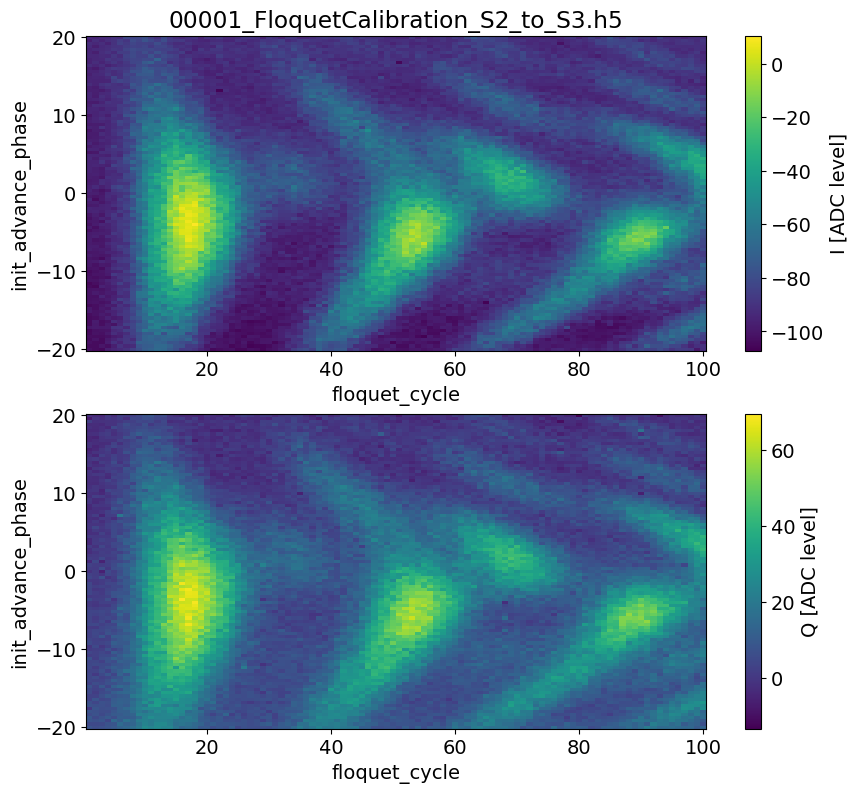

In [60]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 2, # storage mode number to initialize to n=1 Fock state
    ro_stor = 3, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = np.linspace(-20,20,101).tolist(), # advance phase of each successive pulse for the init mode[degrees]
    ro_advance_phase = 6,
    # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
    swept_params = ['init_advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

fce = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = FloquetCalibrationProgram,
    progress=True)

fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
fce.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_FloquetCalibration_S3_to_S2.h5


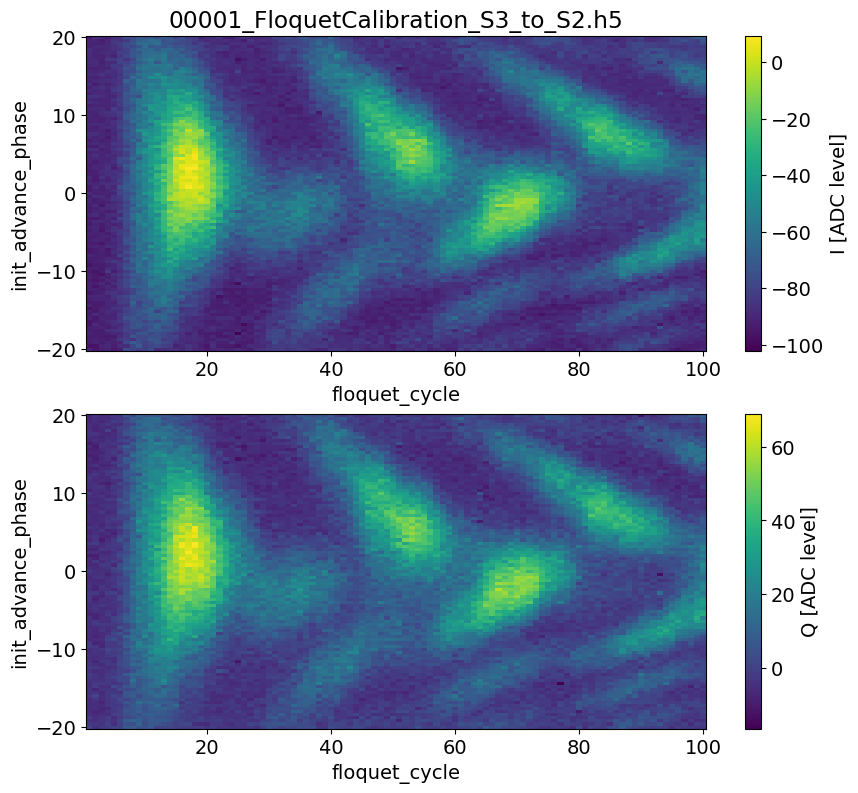

In [61]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 3, # storage mode number to initialize to n=1 Fock state
    ro_stor = 2, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = np.linspace(-20,20,101).tolist(), # advance phase of each successive pulse for the init mode[degrees]
    ro_advance_phase = -8,
    # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
    swept_params = ['init_advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

fce = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = FloquetCalibrationProgram,
    progress=True)

fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
fce.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00012_SidebandScramble_S1_to_S2.h5


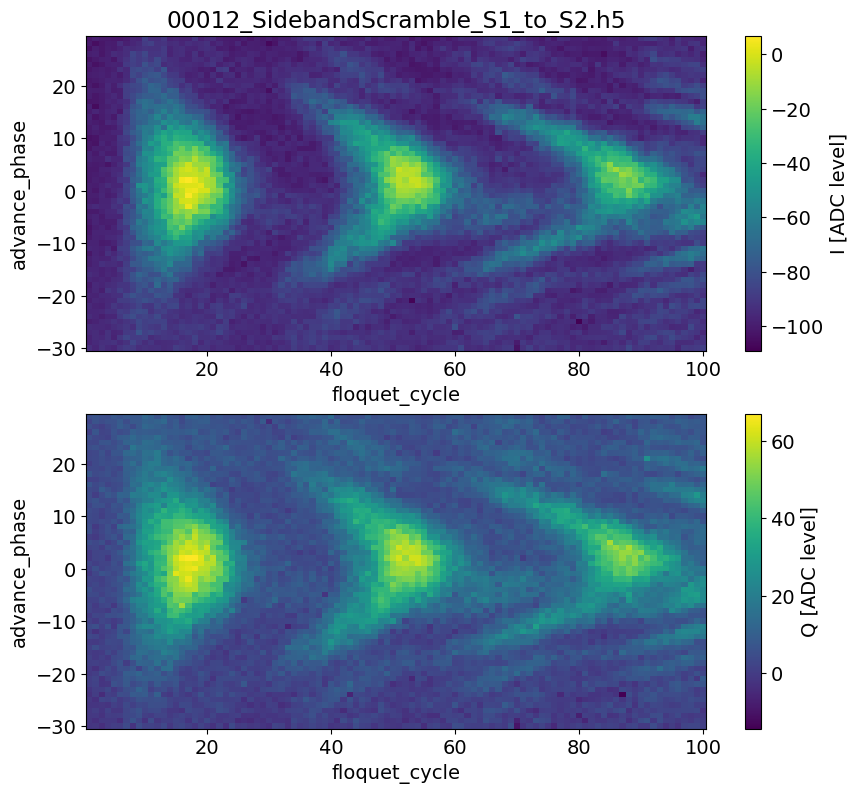

In [ ]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 1, # storage mode number to initialize to n=1 Fock state
    ro_stor = 3, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = list(range(-10,10,0.5)), # advance phase of each successive pulse [degrees]
    ro_advance_phases = list(range(-1k,30,1)), # advance phase of each successive pulse [degrees]
    # advance_phase=0,
    swept_params = ['advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    # swap_stors = [1, 2],
    # update_phases = True, 
    echoes = [False, 0], # [on/off, number of echoes]
)

sbs = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = SidebandScrambleProgram,
    progress=True)

sbs.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
sbs.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00013_SidebandScramble_S1_to_S2.h5


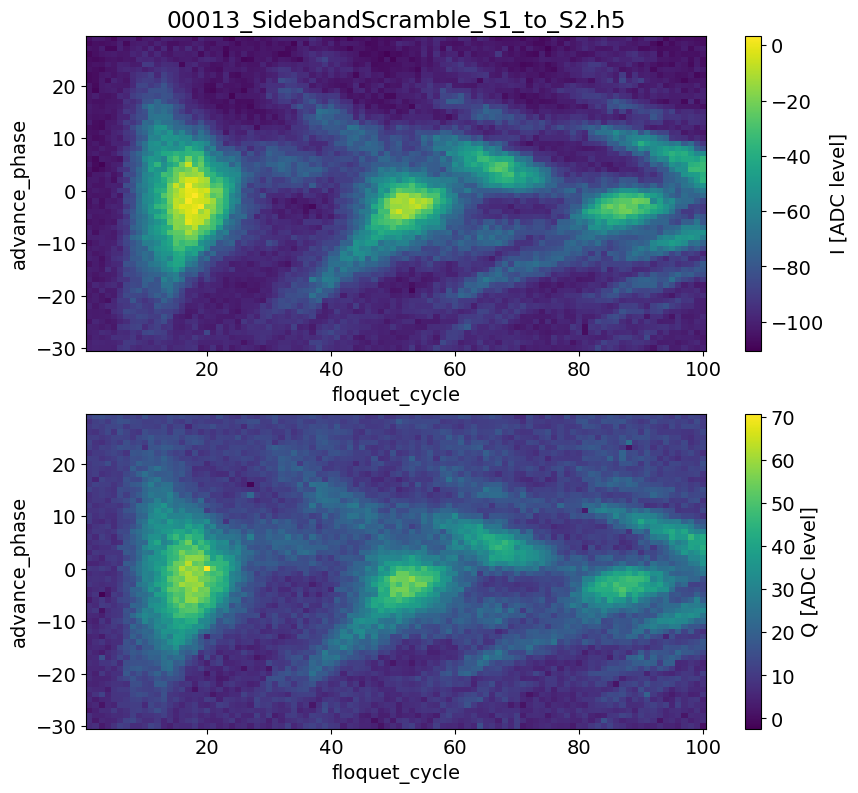

In [46]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 1, # storage mode number to initialize to n=1 Fock state
    ro_stor = 2, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    # gain_div = 3,
    # length_div = 2,
    # detune=0,
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    advance_phases = list(range(-30,30,1)), # advance phase of each successive pulse [degrees]
    # advance_phase=0,
    swept_params = ['advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    # swap_stors = [1, 2],
    # update_phases = True, 
    echoes = [False, 0], # [on/off, number of echoes]
)

sbs = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = SidebandScrambleProgram,
    progress=True)

sbs.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
sbs.go(analyze=False, display=True, progress=True, save=True)

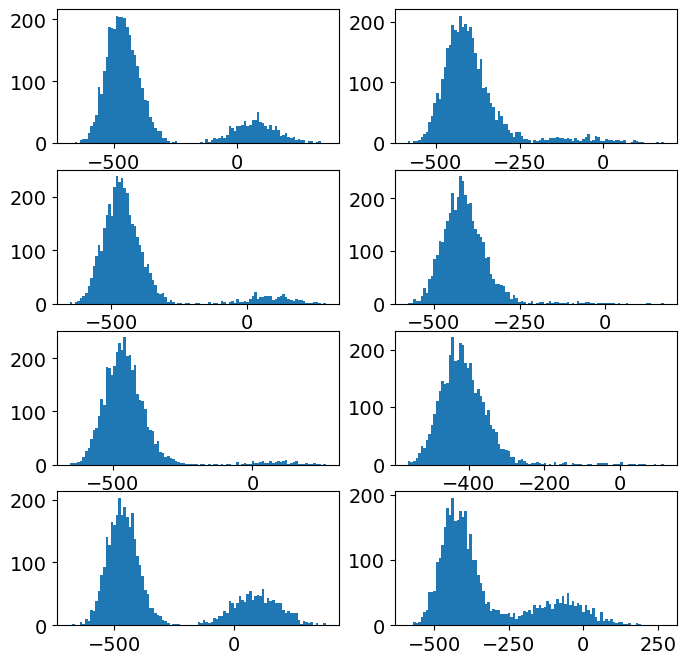

In [98]:
idata = np.array(sbs.data['idata']).ravel()
idata = idata.reshape((len(idata)//4,4))

qdata = np.array(sbs.data['qdata']).ravel()
qdata = qdata.reshape((len(qdata)//4,4))

fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
for kk in range(4):
    axs[kk,0].hist(idata[:,kk], bins=100)
    axs[kk,1].hist(qdata[:,kk], bins=100)
None

In [263]:
for init_stor in range(3,8):
    # for ro_stor in range(8):
    ro_stor = 0
    for detune in np.linspace(-0.2,0.2,21):
        expt_params = dict(
            expts = 1,
            reps = 1000,
            rounds = 1,
            qubits = [0],
            f0g1_cavity = 1,  #  1/2 name of manipulate cavity
            init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
            ro_stor = ro_stor, # storage mode number that gets read out in the end
            # if 0, this means to read out man instead
            floquet_cycles = list(range(1,101)),
            detune=detune,
            normalize = False,
            active_reset = True,
            man_reset = True, 
            storage_reset = True, 
            advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
            echoes = [False, 0], # [on/off, number of echoes]
        )
        
        sbs = SidebandScrambleExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
            config_file=config_path,
            expt_params = expt_params,
            progress=True)
        
        sbs.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
        sbs.go(analyze=False, display=False, progress=False, save=True)

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00001_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00002_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00003_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00004_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00005_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00006_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00007_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00008_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00009_SidebandS

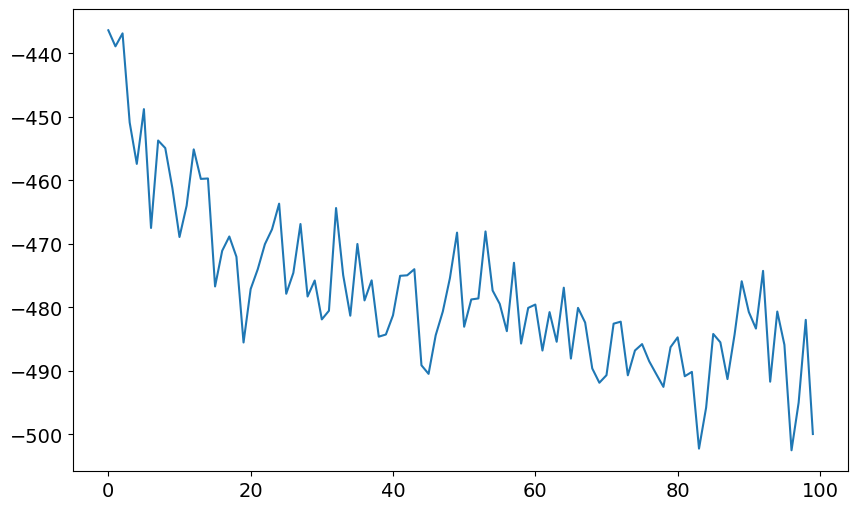

In [259]:
plt.plot(ss[9].data['avgi'])

## Amplitude Rabi

In [11]:
from multimode_expts.experiments.qsim.sideband_amp_rabi import SidebandAmpRabiExperiment

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.floquet_general
imported experiments.qsim.qsim_base
imported experiments.qsim.qsim_experiments
imported experiments.qsim.sideband_amp_rabi
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.sideband_ramsey_scramble
imported experiments.qsim.sideband_scramble
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
imported experiments.qubit_cavity.non_demoluti

In [47]:
for init_stor in range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 500,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        detunes=np.linspace(-2,2,101).tolist(),
        gains=list(range(0,20000,100)),
        length=3, # us rabi pulse legnth
        normalize = False,
        active_reset = True,
        man_reset = True, 
        storage_reset = True, 
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sare = SidebandAmpRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandAmpRabi_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    sare.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
    sare.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S1.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S2.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S3.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S4.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S5.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S6.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S7.h5


## Find phase offset for ramsey

In [14]:
from multimode_expts.experiments.qsim.sideband_stark import SidebandStarkExperiment, SidebandStarkProgram

In [15]:
# for init_stor in range(1, 8):
for init_stor in range(1, 3):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 100,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        detune = 0,
        advance_phases=np.linspace(-90,90,31).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,30,31).tolist(),
        swept_params = ['advance_phase', 'wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        # advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sta = SidebandStarkExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        program=SidebandStarkProgram,
        progress=True)
    
    sta.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sta.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/31 [00:00<?, ?it/s]

pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1', 'pi', 0]
channel name man
pulse param ['M1-S1', 'pi', 0]
channel name storage
pulse_data [[3571.6994214615424 3428.4457610447353 2011.6693654525284
  348.702401768369]
 [3429 2770 8000 3000]
 [0.0 0.0 0.5408883810926033 0.9174265564762912]
 [0 0 0 0]
 [2 2 0 1]
 ['gauss' 'gauss' 'flat_top' 'flat_top']
 [0.035 0.035 0.005 0.005]]
pulse param ['M1', 'pi', 0]
channel name man
pulse_data [[2011.6693654525284]
 [8000]
 [0.5408883810926033]
 [0]
 [0]
 ['flat_top']
 [0.005]]
pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1

  0%|          | 0/31 [00:00<?, ?it/s]

pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1', 'pi', 0]
channel name man
pulse param ['M1-S2', 'pi', 0]
channel name storage
pulse_data [[3571.6994214615424 3428.4457610447353 2011.6693654525284
  520.1370383281906]
 [3429 2770 8000 5000]
 [0.0 0.0 0.5408883810926033 1.084581933496189]
 [0 0 0 0]
 [2 2 0 1]
 ['gauss' 'gauss' 'flat_top' 'flat_top']
 [0.035 0.035 0.005 0.005]]
pulse param ['M1', 'pi', 0]
channel name man
pulse_data [[2011.6693654525284]
 [8000]
 [0.5408883810926033]
 [0]
 [0]
 ['flat_top']
 [0.005]]
pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1

c:\Users\26049\.conda\envs\slab\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


AC Stark freq: 0.199627MHz


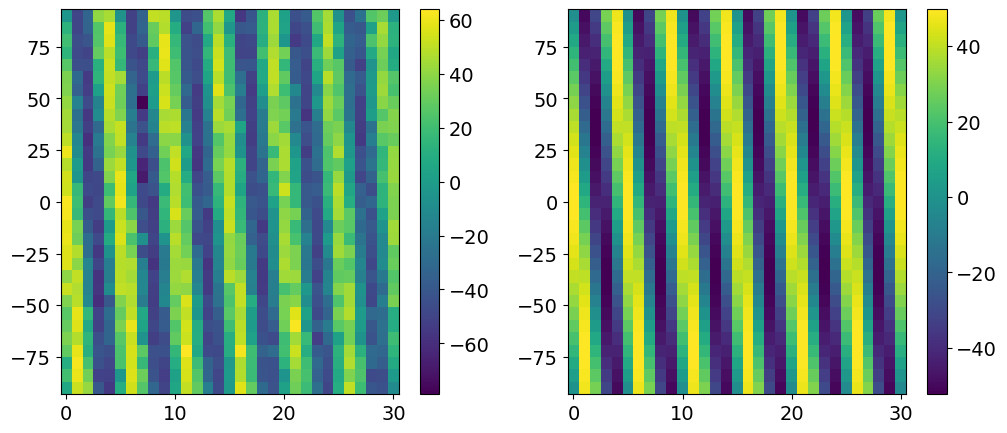

In [17]:
sta.analyze()

In [19]:
for init_stor in [1]: #range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 500,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        detune = 0,
        phases=np.linspace(-90,90,91).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,2,51).tolist(),
        swept_params = ['phase', 'wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = True,
        man_reset = True, 
        storage_reset = True, 
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sta = SidebandStarkExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    sta.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
    sta.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/91 [00:00<?, ?it/s]

KeyboardInterrupt: 

### new base class general 2D

In [20]:
from multimode_expts.experiments.qsim.sideband_stark import SidebandStarkProgram
from multimode_expts.experiments.qsim.qsim_base import QsimBaseExperiment

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00002_SidebandStark_S2.h5


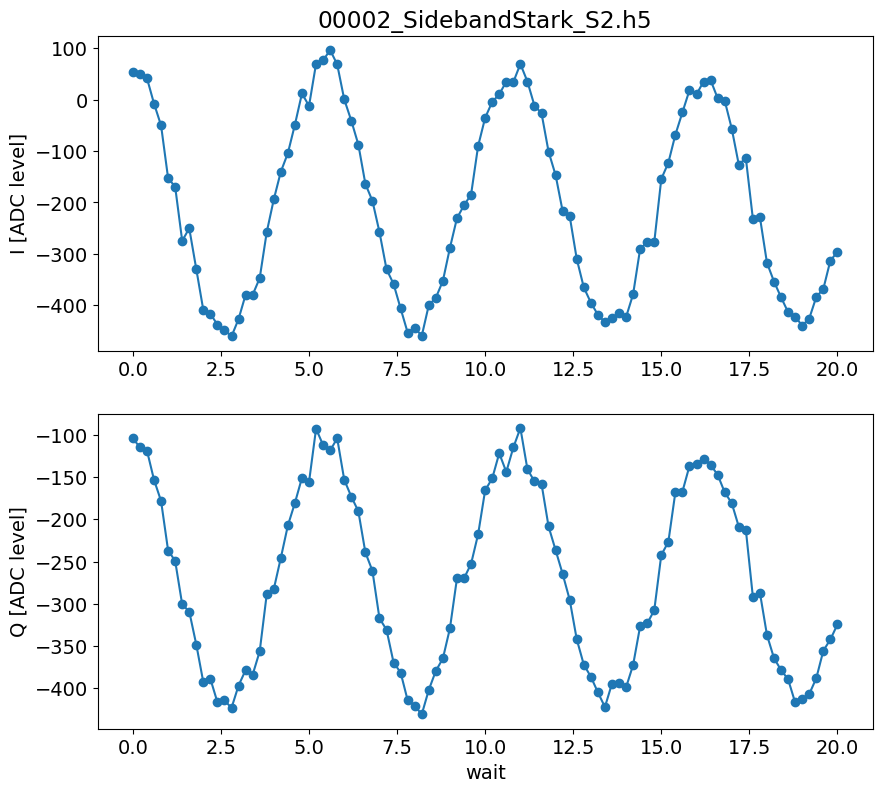

In [106]:
for init_stor in [2]: #range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 100,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        detune = 0,
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        # advance_phases=np.linspace(-90,90,91).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,20,101).tolist(),
        swept_params = ['wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    qbe = QsimBaseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params=expt_params,
        program=SidebandStarkProgram,
        progress=True)
    
    qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    qbe.go(analyze=False, display=True, progress=True, save=True)

### T1

In [54]:
from multimode_expts.experiments.qsim.sideband_scramble import StorageT1Program

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_StorageT1_S0.h5


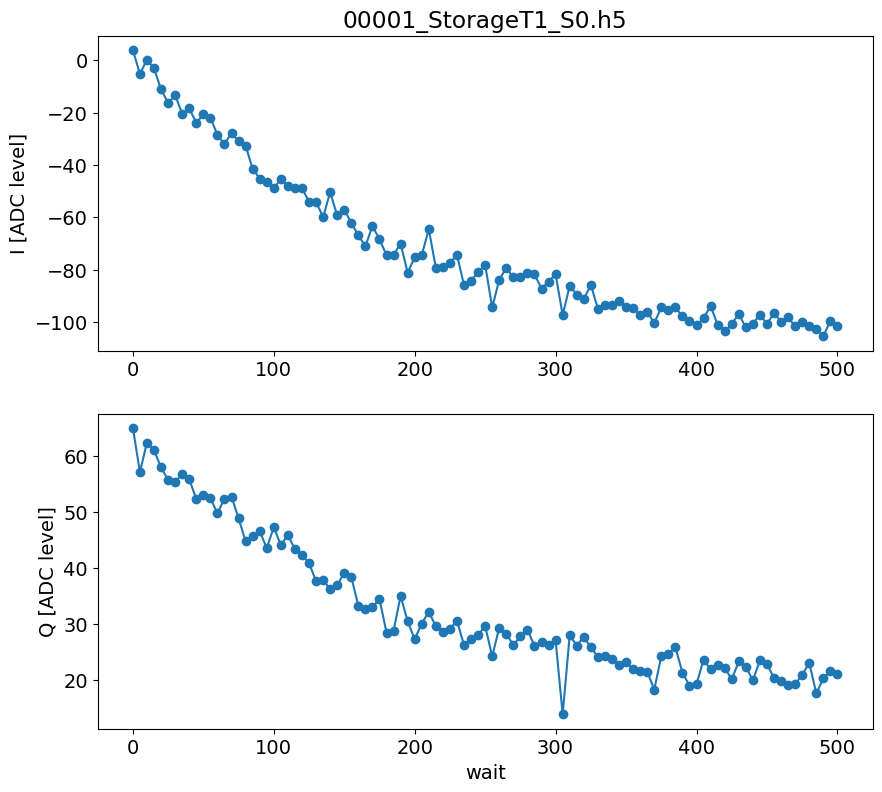

In [59]:
init_stor = 0
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
    ro_stor = init_stor, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    # wait=10, # wait time between two hpi pulses in us
    waits = np.linspace(0,500,101).tolist(),
    swept_params = ['wait'],
    # usage: if you want to sweep cfg.expt.paramName, 
    # include paramName here in this list 
    # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
    # (You want a list instead of numpy array for better yaml export.)
    # Currently handles 1D and 2D sweeps and plots only.
    # For 2D, order is [outer, inner].
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    echoes = [False, 0], # [on/off, number of echoes]
)

qbe = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"StorageT1_S{expt_params['init_stor']}",
    config_file=config_path,
    expt_params=expt_params,
    program=StorageT1Program,
    progress=True)

qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
qbe.go(analyze=False, display=True, progress=True, save=True)

# Kerr engineering

In [19]:
from multimode_expts.experiments.qsim.kerr import KerrEngBaseProgram

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.deprecated
imported experiments.qsim.floquet_chevron
imported experiments.qsim.floquet_offdiag_phasecal
imported experiments.qsim.kerr
imported experiments.qsim.qsim_base
imported experiments.qsim.sideband_amp_rabi
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.sideband_scramble
imported experiments.qsim.sideband_stark
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_c

  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00009_KerrQBHeating.h5


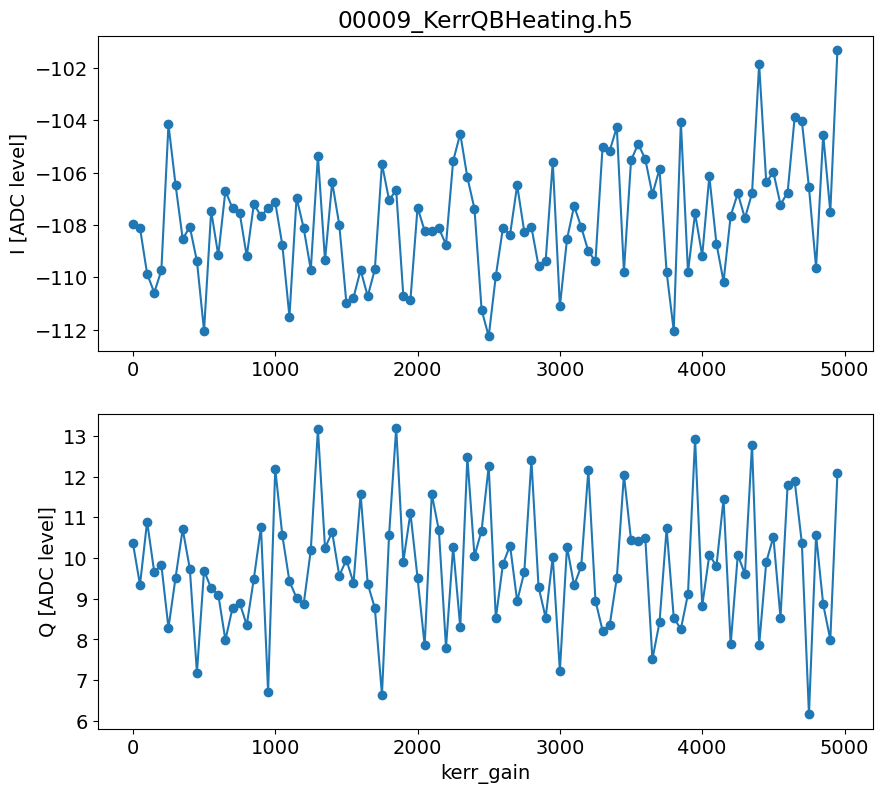

In [44]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 0, # storage mode number to initialize to n=1 Fock state
    ro_stor = 0, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    echoes = [False, 0], # [on/off, number of echoes]
    # === new class
    # kerr_gain = 1000,
    kerr_detune = -50,
    kerr_length = 10,
    swept_params = ['kerr_gain'],
    # kerr_lengths = np.linspace(0.007,5,21).tolist(),
    kerr_gains = np.arange(0,5000,50).tolist(),
    prepulse = False,
    postpulse = False,
)

qbe = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"KerrQBHeating",
    config_file=config_path,
    expt_params=expt_params,
    program=KerrEngBaseProgram,
    progress=True)

qbe.cfg.device.readout.relax_delay = [2000]  # Wait time between experiments [us]
qbe.go(analyze=False, display=True, progress=True, save=True)

## Cavity Ramsey versus gain 

This is to find out $\chi$, $\chi'$, $\Delta$ and $K_c$

In [19]:
def do_cavity_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    prep_e_first = True,
    relax_delay=2500      # relax delay
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True,
                              config_thisrun.device.manipulate.f_ge[man_mode_no-1], 
                              10, 
                              config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 
                              0,
                              4]
        
    #[on/off, freq, gain, sigma (mus), length, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    cavity_ramsey = expts_base_inst.meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse, # post sweep pulse
        prep_e_first=prep_e_first,  # prepare e first
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey



In [20]:
def do_cavity_ramsey_gain_sweep(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    gain_start = 1000,  # start gain
    gain_step = 1000,      # step size for gain
    gain_expts = 5,        # number of experiments for gain
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    relax_delay=2500,      # relax delay
    do_g_and_e=False, # do e-f first
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True,
                              config_thisrun.device.manipulate.f_ge[man_mode_no-1], 
                              1000, 
                              config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 
                              0,
                              4]
    #[on/off, freq, gain, sigma (mus), length, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyGainSweepExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyGainSweepExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        gain_start=gain_start,          # start gain
        gain_step=gain_step,            # step size for gain
        gain_expts=gain_expts,          # number of experiments for gain
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse, # post sweep pulse
        do_g_and_e=do_g_and_e,  # do e-f first

        qubit_drive_pulse=[True],
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey



In [32]:
gain_start = 2000
gain_stop = 12000
gain_step = 600
gain_expts = int((gain_stop - gain_start) / gain_step) + 1
print(f'Gain start: {gain_start}, Gain stop: {gain_stop}, Gain step: {gain_step}, Gain expts: {gain_expts}')

Gain start: 2000, Gain stop: 12000, Gain step: 600, Gain expts: 17


In [34]:
cavity_ramsey_sweep = do_cavity_ramsey_gain_sweep(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    gain_start=gain_start,  # start gain
    gain_step=gain_step,      # step size for gain
    gain_expts=gain_expts,        # number of experiments for gain
    ramsey_freq=1.6,
    step = 0.04, 
    expts = 150, 
    reps = 100,
    do_g_and_e=True,
)

  0%|          | 0/17 [00:00<?, ?it/s]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

  6%|▌         | 1/17 [01:15<20:14, 75.91s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 12%|█▏        | 2/17 [02:31<18:57, 75.84s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 18%|█▊        | 3/17 [03:47<17:41, 75.82s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 24%|██▎       | 4/17 [05:03<16:25, 75.80s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 29%|██▉       | 5/17 [06:19<15:10, 75.90s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 35%|███▌      | 6/17 [07:35<13:54, 75.87s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 41%|████      | 7/17 [08:51<12:38, 75.88s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 47%|████▋     | 8/17 [10:06<11:22, 75.86s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 53%|█████▎    | 9/17 [11:22<10:06, 75.84s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 59%|█████▉    | 10/17 [12:38<08:50, 75.83s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 65%|██████▍   | 11/17 [13:54<07:34, 75.83s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 71%|███████   | 12/17 [15:10<06:19, 75.83s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 76%|███████▋  | 13/17 [16:25<05:03, 75.81s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 82%|████████▏ | 14/17 [17:41<03:47, 75.81s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 88%|████████▊ | 15/17 [18:57<02:31, 75.81s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 94%|█████████▍| 16/17 [20:13<01:15, 75.79s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

100%|██████████| 17/17 [21:29<00:00, 75.83s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00006_CavityRamseyGainSweepExperiment.h5


gain_to_alpha 0.0007351777556463477
Kerr : -4.826 +/- 3.148 kHz
detuning Ground State: -33.794 +/- 116.270 kHz
Chi: -378.152 +/- 130.616 kHz
Chi2: 1.649 +/- 1.768 kHz


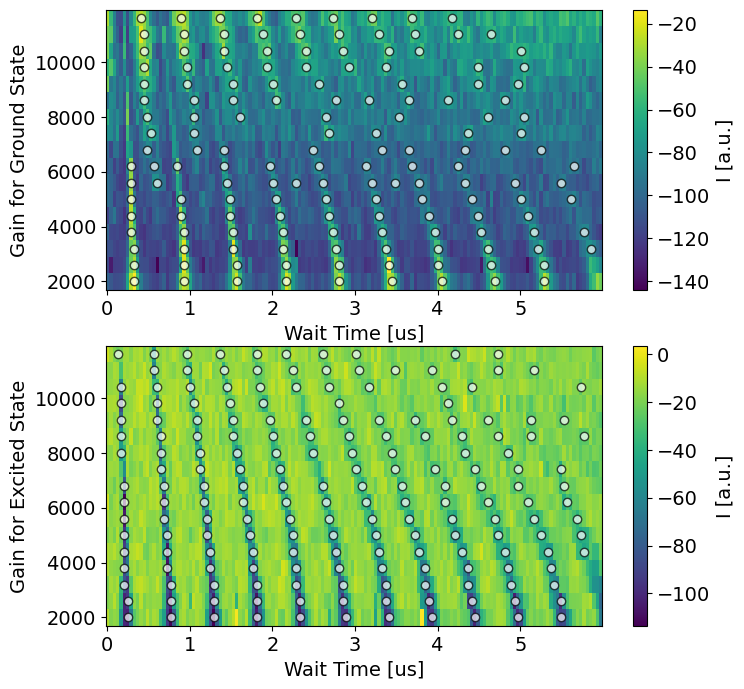

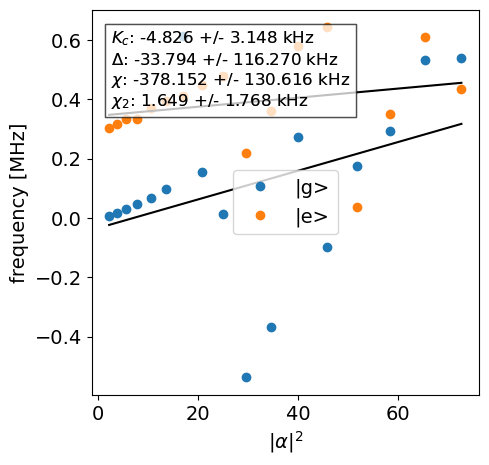

In [35]:
cavity_ramsey_sweep.analyze()
cavity_ramsey_sweep.display()
delta_g = cavity_ramsey_sweep.data['detuning_g']

# config_thisrun.device.manipulate.f_ge[0] -= delta_g
# print(f"Updated f_ge frequency: {config_thisrun.device.manipulate.f_ge[0]} MHz")

## with kerr

In [21]:
from multimode_expts.experiments.qsim.kerr import KerrCavityRamseyProgram

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.deprecated
imported experiments.qsim.floquet_chevron
imported experiments.qsim.floquet_offdiag_phasecal
imported experiments.qsim.kerr
imported experiments.qsim.qsim_base
imported experiments.qsim.sideband_amp_rabi
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.sideband_scramble
imported experiments.qsim.sideband_stark
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_c

In [30]:
def do_kerr_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    prep_e_first = True,
    relax_delay=2500      # relax delay
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True,
                              config_thisrun.device.manipulate.f_ge[man_mode_no-1], 
                              10000, 
                              config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 
                              0,
                              4]
        
    #[on/off, freq, gain, sigma (mus), length, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    expt_params = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse, # post sweep pulse
        prep_e_first=prep_e_first,  # prepare e first
        normalize = False,
        # kerr_gain = 10,
        kerr_gains = np.arange(10,10010,500).tolist(),
        kerr_detune = -50,
        # kerr_length = 10,
        swept_params = ['kerr_gain', 'kerr_length'],
        kerr_lengths = np.linspace(0.007,2,101).tolist(),
        # kerr_gains = np.arange(0,5000,50).tolist(),
    )

    cavity_ramsey = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"KerrRamseyExperiment",
    config_file=config_path,
    expt_params=expt_params,
    program=KerrCavityRamseyProgram,
    progress=True)

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = expt_params

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=True, progress=True, save=True)
    return cavity_ramsey


  0%|          | 0/20 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00019_KerrRamseyExperiment.h5


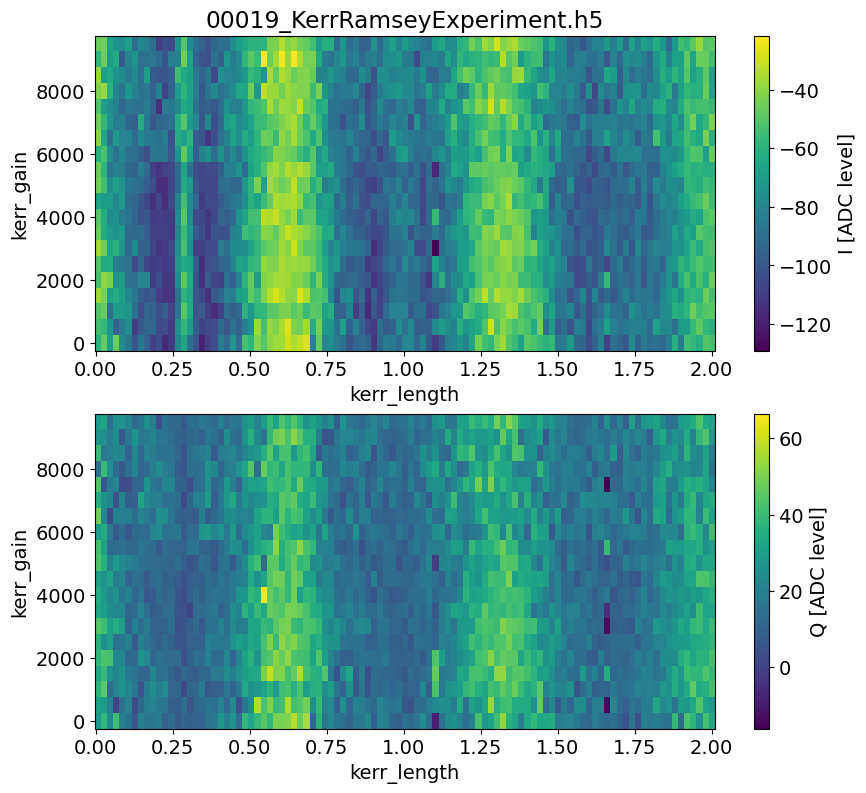

In [31]:
kerr_ramsey = do_kerr_ramsey(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    ramsey_freq=1,
    # step = 0.04, 
    # expts = 150, 
    reps = 100,
    prep_e_first=False,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00015_KerrRamseyExperiment.h5


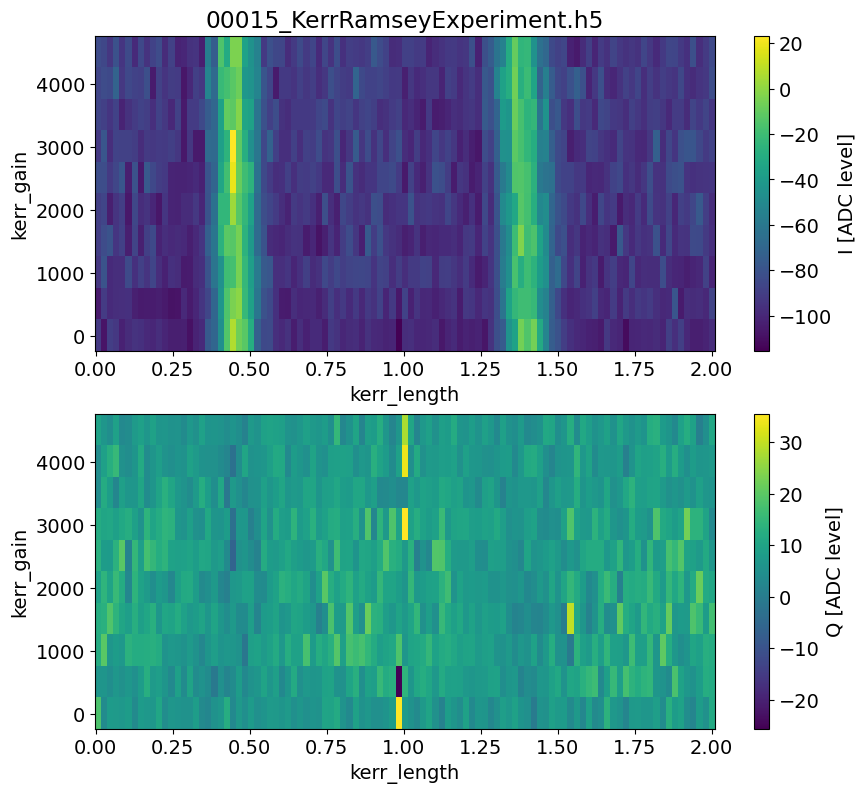

In [36]:
kerr_ramsey = do_kerr_ramsey(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    ramsey_freq=1,
    # step = 0.04, 
    # expts = 150, 
    reps = 100,
    prep_e_first=False,
)

# Ramp current

In [ ]:
# coupler
dcflux = YokogawaGS200(address="192.168.137.148")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.00032, sweeprate=0.0001)

In [ ]:
# jpa
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.000, sweeprate=0.002)

In [ ]:
# dcflux = YokogawaGS200(address="192.168.137.148")
#     dcflux.set_output(True)
#     dcflux.set_mode('current')
#     dcflux.ramp_current(0.000, sweeprate=0.002)